In [64]:
import pandas as pd
import seaborn as sns
from IPython.display import Image, SVG, set_matplotlib_formats
from matplotlib import pyplot as plt
import multiprocessing
import numpy as np
from scipy.stats import pearsonr
import allel
import demes
import demesdraw
import os
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
#The default figure size is small, this increases the default:
plt.rcParams['figure.figsize'] = [15, 7]
plt.rcParams['font.size'] = 16
px = 1/plt.rcParams['figure.dpi']  # pixel in inches

In [2]:
__version__ = 0.2

Importing gIMble summary statistics for windows of length 50_000 & 64bp pair-blocks:

In [2]:
wins_500_f = "laetsch_et_al_2023_data/heliconius.v1.windows.popgen.bed"
wins_500_df = pd.read_csv(wins_500_f, sep='\t', header=1).replace('hmel2_5.chr','chr', regex=True).replace('chr0','chr', regex=True)
wins_500_df.columns = [col.lstrip("#").strip() for col in wins_500_df.columns]
wins_500_df.rename(columns = {'heterozygosity_A':'H_cyd', 'heterozygosity_B':'H_mel'}, inplace = True)

I am saving the window midpoints for the recombination analysis: 

In [3]:
pos_mean = pd.DataFrame({'chr': wins_500_df['sequence'] , 'pos_mean':wins_500_df['pos_mean']})
pos_mean.to_csv('winsMidpoints_05_2023.txt',sep='\t',header=False, index=False)

The genome coordinates of the known wing pattern genes are:

In [4]:
wingenes = [['chr10', 3305023, 3368587], ['chr15', 1481522, 1600859], ['chr18', 1058778, 1059581]];

## The distribution of recombination rates and CDS

We have summarised recombination rates (in cM/Mb in males averaged across all three types of crosses analysed by Davey et al (2017)) over different physical distances measured from the midpoint of each gIMble window:

In [182]:
rec_cols=['chrom', 'pos', 'rec']
rec_125kb_df = pd.read_csv('laetsch_et_al_2023_data/rec_HAll_125kb_2023.txt', names=rec_cols, delim_whitespace=True)
rec_250kb_df = pd.read_csv('laetsch_et_al_2023_data/rec_HAll_250kb_2023.txt', names=rec_cols, delim_whitespace=True)
rec_500kb_df = pd.read_csv('laetsch_et_al_2023_data/rec_HAll_500kb_2023.txt', names=rec_cols, delim_whitespace=True)
rec_1000kb_df = pd.read_csv('laetsch_et_al_2023_data/rec_HAll_1000kb_2023.txt', names=rec_cols, delim_whitespace=True)
rec_2000kb_df = pd.read_csv('laetsch_et_al_2023_data/rec_HAll_2000kb_2023.txt', names=rec_cols, delim_whitespace=True)

Since rec rates are for males and there is no recombination in females, the average per generation rec rate in the population is 1/2:

In [183]:
rec_final_125 = pd.DataFrame({'chrom': wins_500_df['sequence'],'start': wins_500_df['start'],'end': wins_500_df['end'], 'rec': rec_125kb_df['rec']/2})
rec_final_250 = pd.DataFrame({'chrom': wins_500_df['sequence'],'start': wins_500_df['start'],'end': wins_500_df['end'], 'rec': rec_250kb_df['rec']/2})
rec_final_500 = pd.DataFrame({'chrom': wins_500_df['sequence'],'start': wins_500_df['start'],'end': wins_500_df['end'], 'rec': rec_500kb_df['rec']/2})
rec_final_1000 = pd.DataFrame({'chrom': wins_500_df['sequence'],'start': wins_500_df['start'],'end': wins_500_df['end'], 'rec': rec_1000kb_df['rec']/2})
rec_final_2000 = pd.DataFrame({'chrom': wins_500_df['sequence'],'start': wins_500_df['start'],'end': wins_500_df['end'], 'rec': rec_2000kb_df['rec']/2})

In [184]:
wins_500_df['rec_125Kb'] = rec_final_125['rec']
wins_500_df['rec_250Kb'] = rec_final_250['rec']
wins_500_df['rec_500Kb'] = rec_final_500['rec']
wins_500_df['rec_1000Kb'] = rec_final_1000['rec']
wins_500_df['rec_2000Kb'] = rec_final_2000['rec']

We will mainly use recombination measured at a 1Mb scale:

The saves the recombination rate as a CSV file (to be used for gIMble simulate):

In [16]:
rec_final_1000.to_csv('rec_final_Hmel_1000kb_2022.txt',sep='\t', header=False, index=False)

In [8]:
median_rec = rec_final_1000['rec'].median()

**Sanity check:** The median $r$ is very close to the (unweighted) mean $r$ we obtain assuming that each autosome has a (sex averaged) map length of 25cM!   

In [9]:
genome_f = "laetsch_et_al_2023_data/gimble.autosomes.genomefile"
genome_df = pd.read_csv(genome_f, sep="\t", usecols=[0,1], names=['sequence_id', 'sequence_length'], dtype={'sequence_id': 'category', 'sequence_length': 'int64'}, header=None)
genome_df['sequence_id'] = genome_df['sequence_id'].str.replace('hmel2_5.','').str.replace('chr0','chr')
genome_pd = pd.pivot_table(genome_df, index='sequence_id')

In [26]:
chrom_l = np.array(genome_pd['sequence_length'])/1e6;
meanr = 25/chrom_l
print(meanr.mean())
print(median_rec)

2.061897172952654
2.00425


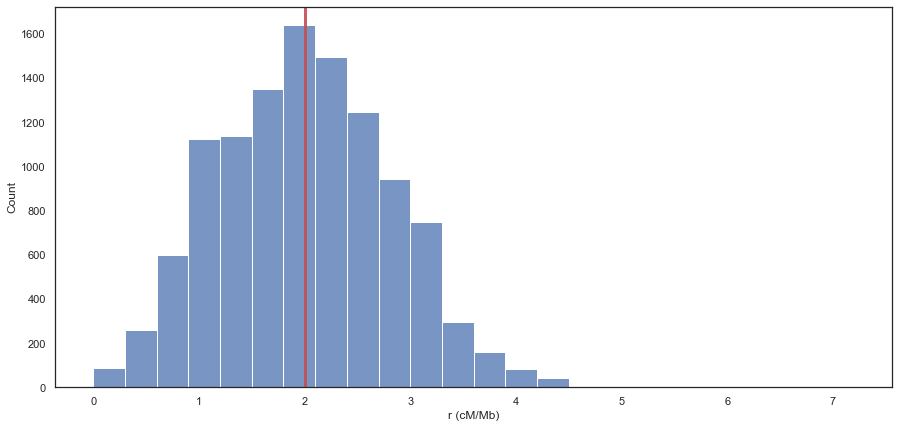

In [27]:
sns.set_theme(style="white")
plt.axvline(x = median_rec, linewidth=3, alpha=0.9, color = 'r')
plt.xlabel('r (cM/Mb)')
sns.histplot(data=rec_final_1000, x=('rec'), binrange = (0,7), binwidth = 0.3)
plt.savefig("figures/rec_hist.png")
plt.show()

The fraction of CDS measured over the same scales:

In [29]:
colnames=['chrom', 'mid', '125kb', '250kb','500kb','1000kb','2000kb','5000kb'] 
cds_ALL_df = pd.read_csv('laetsch_et_al_2023_data/heli_500x64_wins_interg_coord.CHROM.prop_CDS_ALL_05_2023.tsv', sep='\t', names=colnames, header=None)

In [30]:
wins_500_df['CDS_125Kb'] = cds_ALL_df['125kb']
wins_500_df['CDS_250Kb'] = cds_ALL_df['250kb']
wins_500_df['CDS_500Kb'] = cds_ALL_df['500kb']
wins_500_df['CDS_1000Kb'] = cds_ALL_df['1000kb']
wins_500_df['CDS_2000Kb'] = cds_ALL_df['2000kb']

## Visualising window span

In [32]:
wins_500_df['span'] = (wins_500_df.end - wins_500_df.start)/1000
med = wins_500_df['span'].median()
med

103.032

The median physical span of windows is considerably larger than the minimum of $64bp * 500 = 32kb$ (dashed line):

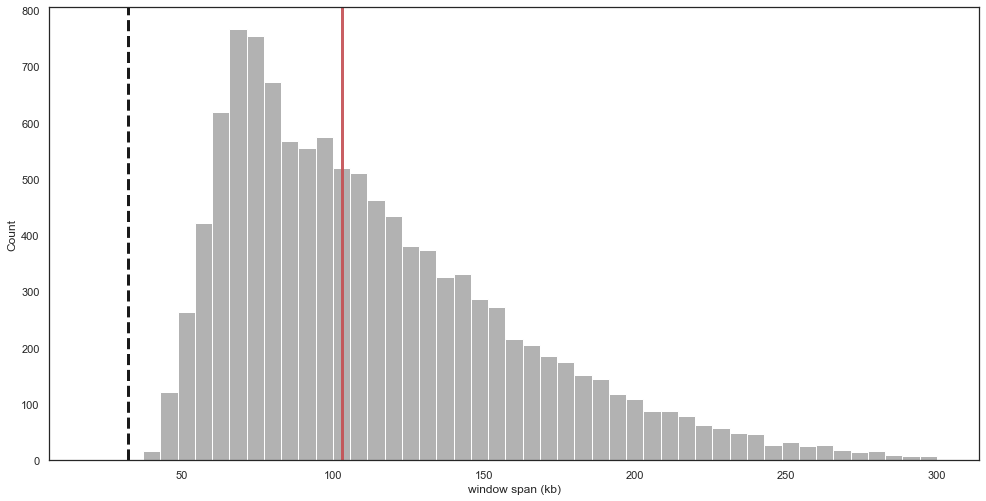

In [88]:
sns.set_theme(style="white")
med = wins_500_df['span'].median()
plt.subplots(figsize=(1200*px, 600*px))
plt.axvline(x = med, linewidth=3, alpha=0.9, color ='r')
plt.axvline(x = 32, linewidth=3, ls = '--', alpha=0.9, color ='black')
plt.xlabel('window span (kb)')
sns.histplot(data=wins_500_df, x=('span'), binrange = (20,300),color = '0.6')
plt.savefig("figures/spanhist.tiff")
plt.savefig("figures/spanhist.png")
plt.show()

## $F_{st}$ outliers are mainly due to reduced $\pi$ 

In [34]:
quantile95_fst = wins_500_df['f_st'].quantile(.95)
median_fst = wins_500_df['f_st'].median()
print(median_fst)

0.14921


This adds a column with Fst outliers to wins_500_df:

In [35]:
wins_500_df['Fst'] = np.where(wins_500_df['f_st'] > quantile95_fst, '95% outlier', 'background')

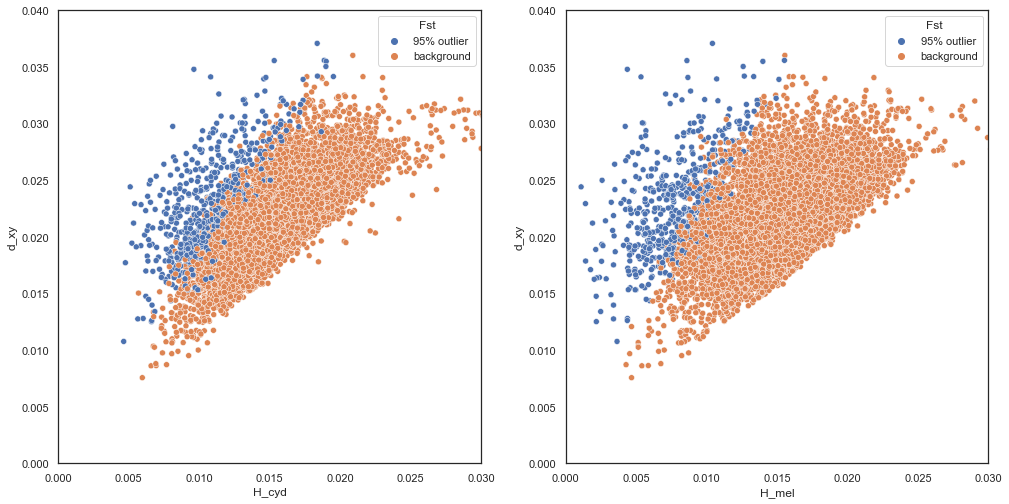

In [89]:
fig, axs = plt.subplots(ncols=2, figsize=(1200*px, 600*px))
sns.scatterplot(data=wins_500_df, x='H_cyd', y="d_xy", hue = 'Fst', ax=axs[0],  hue_order = ('95% outlier', 'background'))
sns.scatterplot(data=wins_500_df, x='H_mel', y="d_xy", hue = 'Fst', ax=axs[1],  hue_order = ('95% outlier', 'background'))                        
axs[0].set(xlim=(0,0.03))
axs[0].set(ylim=(0, 0.04))
axs[1].set(xlim=(0,0.03))
axs[1].set(ylim=(0,0.04))
plt.xlim(0,0.03)
plt.ylim(0,0.04)
plt.savefig("figures/hetBvsdAB.png")
plt.savefig("figures/hetBvsdAB.tiff")
plt.show()

In [37]:
def get_coordinates(genome_f):
    genome_df = pd.read_csv(genome_f, sep="\t", usecols=[0,1], names=['sequence_id', 'sequence_length'], dtype={'sequence_id': 'category', 'sequence_length': 'int64'}, header=None)
    # change sequence names ...
    genome_df['sequence_id'] = genome_df['sequence_id'].str.replace('hmel2_5.','').str.replace('chr0','chr')
    offset_by_sequence_id = {}
    offset = 0
    bg_rectangles = []
    for idx, (sequence_id, sequence_length) in enumerate(list(genome_df.itertuples(index=False, name=None))):
        offset_by_sequence_id[sequence_id] = offset
        bg_rectangles.append((sequence_id, offset, offset + sequence_length))
        offset += sequence_length
    return (offset_by_sequence_id, bg_rectangles)

def get_highlights():
    pass
    
genome_f = "laetsch_et_al_2023_data/gimble.autosomes.genomefile"
offset_by_sequence_id, bg_rectangles = get_coordinates(genome_f)
genome_df = pd.read_csv(genome_f, sep="\t", usecols=[0,1], names=['sequence_id', 'sequence_length'], dtype={'sequence_id': 'category', 'sequence_length': 'int64'}, header=None)

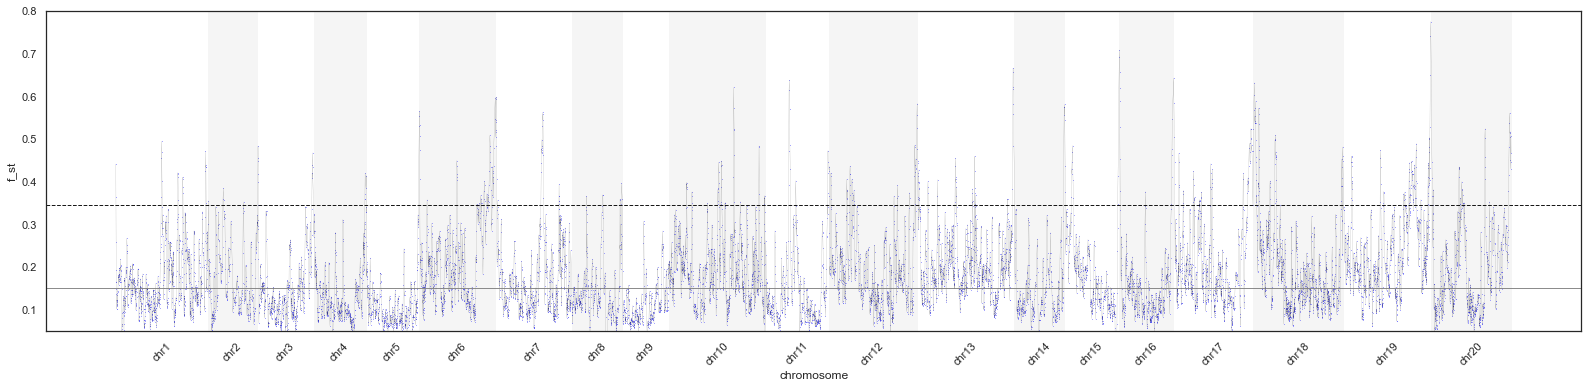

In [90]:
fig, axs = plt.subplots(ncols = 1, figsize=(1600*px, 400*px))
xticks = []
xtick_labels = []
ax_scan = axs
if offset_by_sequence_id and bg_rectangles:
    wins_500_df['x'] = wins_500_df['pos_mean'] + wins_500_df['sequence'].map(offset_by_sequence_id)
    for idx, (sequence_id, axvspan_min, axvspan_max) in enumerate(bg_rectangles):
        if idx % 2 != 0: # only make rectangles for every 2nd one
            ax_scan.axvspan(axvspan_min, axvspan_max, color='whitesmoke', zorder=-1)
        xticks.append(axvspan_min+(axvspan_max - axvspan_min)/2)
        xtick_labels.append(sequence_id)
    xlabel="chromosome"
else:
    wins_500_df['x'] = wins_500_df['pos_mean']
    xlabel=wins_500_df["sequence"].unique()[0]
# dots
ax_scan = sns.scatterplot(data=wins_500_df, x="x",  y= "f_st", color='blue', s=0.5)
# lines
ax_scan = sns.lineplot(data=wins_500_df, x="x",  y= "f_st", color='black', alpha=0.4, lw=0.2) 
# xticks
ax_scan.set_xticks(xticks)
ax_scan.set_xticklabels(xtick_labels, rotation=45)
ax_scan.set_xlabel(xlabel)
plt.ylim(0.05, 0.8)
plt.axhline(y = quantile95_fst, linewidth=3, ls = '--', lw=1, alpha=0.9, color ='black')
plt.axhline(y = median_fst, linewidth=3, ls = '-', lw=1, alpha=0.9, color ='grey')
plt.tight_layout()
out_prefix = "figures/fstscan"
out_ff = '%s.tiff' % out_prefix
out_f = '%s.png' % out_prefix
fig.savefig(out_ff)
fig.savefig(out_f)

In [39]:
mean_d_xy = wins_500_df['d_xy'].mean()
mean_H_cyd = wins_500_df['H_cyd'].mean()
mean_H_mel = wins_500_df['H_mel'].mean()
print([mean_d_xy, mean_H_cyd, mean_H_mel])

[0.022047937059819916, 0.01587954265846483, 0.015596756708567354]


In [68]:
plt.rcParams['font.size'] = 18

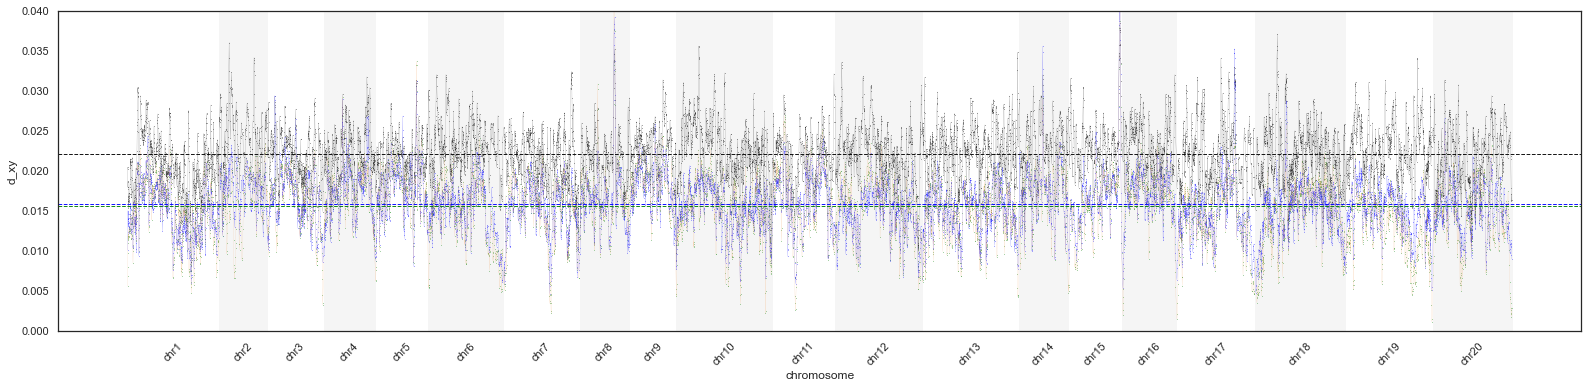

In [91]:
fig, axs = plt.subplots(ncols =1, figsize=(1600*px, 400*px))
xticks = []
xtick_labels = []
ax_scan = axs
if offset_by_sequence_id and bg_rectangles:
    wins_500_df['x'] = wins_500_df['pos_mean'] + wins_500_df['sequence'].map(offset_by_sequence_id)
    for idx, (sequence_id, axvspan_min, axvspan_max) in enumerate(bg_rectangles):
        if idx % 2 != 0: # only make rectangles for every 2nd one
            ax_scan.axvspan(axvspan_min, axvspan_max, color='whitesmoke', zorder=-1)
        xticks.append(axvspan_min+(axvspan_max - axvspan_min)/2)
        xtick_labels.append(sequence_id)
    xlabel="chromosome"
else:
    wins_500_df['x'] = wins_500_df['pos_mean']
    xlabel=wins_500_df["sequence"].unique()[0]
# dots
ax_scan = sns.scatterplot(data=wins_500_df, x="x",  y= "d_xy", color='black', s=0.5)
ax_scan = sns.scatterplot(data=wins_500_df, x="x",  y= "H_cyd", color='blue', s=0.5)
ax_scan = sns.scatterplot(data=wins_500_df, x="x",  y= "H_mel", color='green', s=0.5)
# lines
ax_scan = sns.lineplot(data=wins_500_df, x="x",  y= "d_xy", color='black', alpha=0.5, lw=0.2)
ax_scan = sns.lineplot(data=wins_500_df, x="x",  y= "H_cyd", color='blue', alpha=0.5, lw=0.2)
ax_scan = sns.lineplot(data=wins_500_df, x="x",  y= "H_mel", color='sandybrown', alpha=0.5, lw=0.2)
# xticks
ax_scan.set_xticks(xticks)
ax_scan.set_xticklabels(xtick_labels, rotation=45)
ax_scan.set_xlabel(xlabel)
plt.ylim(0, 0.04)
plt.axhline(y = mean_d_xy, linewidth=3, ls = '--', lw=1, alpha=0.9, color ='black')
plt.axhline(y = mean_H_cyd, linewidth=3, ls = '--', lw=1, alpha=0.9, color ='blue')
plt.axhline(y = mean_H_mel, linewidth=3, ls = '--', lw=1, alpha=0.9, color ='green')
plt.tight_layout()
out_prefix = "figures/dxyscan"
out_ff = '%s.tiff' % out_prefix
out_f = '%s.png' % out_prefix
fig.savefig(out_ff)
fig.savefig(out_f)

# The best global model

Note: I changed the population labels in the yaml file as follows: A -> H_cydno, B -> H_melpomene, A_B -> ancestor.

In [41]:
demes_IM =demes.load("laetsch_et_al_2023_data/heliconius.v1.optimize_windows.windowsum_IM_BA.optimize.demes.yaml")

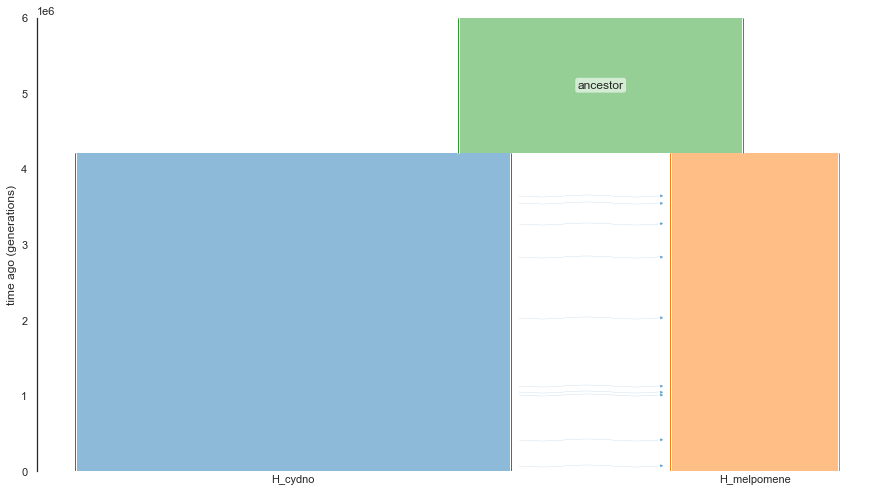

In [42]:
demesdraw.tubes(demes_IM, max_time=6e6, positions = {"ancestor":1e6, "H_cydno":0, "H_melpomene":1.5e6}, colours ={"ancestor":'#2ca02c', "H_cydno":'#1f77b4', "H_melpomene":'#ff7f0e'})
plt.savefig('figures/trouser_leg_HmelHcyd.tiff', dpi = 100)
plt.show()

The 95% confidence intervals of MCLEs under this model, can be approximated as +/- 2 SD across bootstrap replicates:

In [43]:
bootstrap_IM_IM_f = "laetsch_et_al_2023_data/heliconius.v1.optimize_IM_BA_subsample.windowsum_IM_BA.optimize_100reps.tsv"
bootstrap_IM_IM_pd = pd.read_csv(bootstrap_IM_IM_f, sep = '\t', header =1);

In [44]:
mcle_IM_BA = np.array([1_415_373.71, 549_442.99,927_925.70, 7.4122691107e-07, 4_214_353.59])

In [45]:
std_list=[np.std(bootstrap_IM_IM_pd.Ne_A), np.std(bootstrap_IM_IM_pd.Ne_B), np.std(bootstrap_IM_IM_pd['Ne_A_B']), np.std(bootstrap_IM_IM_pd.me), np.std(bootstrap_IM_IM_pd['T'])]
print(np.round(mcle_IM_BA))
print(np.round(mcle_IM_BA - 2*np.array(std_list)))
print(np.round(mcle_IM_BA + 2*np.array(std_list)))

[1415374.  549443.  927926.       0. 4214354.]
[1399145.  535891.  924504.       0. 4185810.]
[1431603.  562995.  931348.       0. 4242897.]


The split time is measured in generations, assuming 4 generations per year gives an estimate in years:

In [46]:
print(np.round([mcle_IM_BA[4] /4, 4185810/4, 4242897./4]))

[1053588. 1046452. 1060724.]


In [47]:
print(mcle_IM_BA[3])
print((mcle_IM_BA - 2*np.array(std_list))[3])
print((mcle_IM_BA + 2*np.array(std_list))[3])

7.4122691107e-07
7.296360916524818e-07
7.528177304875181e-07


Note that $N_A$, $N_B$ and $T$ are overestimated, $N_{AB}$ is severely underestimated:

In [156]:
mean_list=[np.mean(bootstrap_IM_BA_pd.Ne_A), np.mean(bootstrap_IM_BA_pd.Ne_B), np.mean(bootstrap_IM_BA_pd['Ne_A_B']), np.mean(bootstrap_IM_BA_pd.me), np.mean(bootstrap_IM_BA_pd['T'])]
print(np.round(mean_list))

[1626727.  713699.   51239.       0. 4623246.]


# The best model of heterogeneous $N_e$ and $m_e$

The best supported model for each window is:

In [48]:
lik_best_f_heli = "laetsch_et_al_2023_data/heliconius.v1.gridsearch_windows_IM_BA_final_0.best.bed"
lik_best_pd_heli = pd.read_csv(lik_best_f_heli, sep = '\t', header =1);
lik_best_pd_heli.columns = [col.lstrip("#").strip() for col in lik_best_pd_heli.columns]
lik_best_pd_heli['sequence'] = lik_best_pd_heli['sequence'].str.replace('hmel2_5.chr0','chr').str.replace('hmel2_5.chr','chr')                                                                

The best fitting parameter estimates under the MIG model (the 2nd best model) for each window are: 

In [49]:
lik_mig_f_heli = "laetsch_et_al_2023_data/heliconius.v1.gridsearch_windows_MIG_BA_0.best.bed"
lik_mig_pd_heli = pd.read_csv(lik_mig_f_heli, sep = '\t', header =1);
lik_mig_pd_heli.columns = [col.lstrip("#").strip() for col in lik_mig_pd_heli.columns]
lik_mig_pd_heli['sequence'] = lik_mig_pd_heli['sequence'].str.replace('hmel2_5.chr0','chr').str.replace('hmel2_5.chr','chr')                                                                

It is convenient to add these parameter estimates to wins_500_df:

In [50]:
wins_500_df['me'] = lik_best_pd_heli['me']
wins_500_df['MIG_me'] = lik_mig_pd_heli['me']
wins_500_df['N_cyd'] =lik_best_pd_heli['Ne_A']
wins_500_df['N_mel'] =lik_best_pd_heli['Ne_B']
wins_500_df['N_and'] =lik_best_pd_heli['Ne_A_B']

It is reassuring that the genome wide mean estimates for windows (under a model in which BOTH $m_e$ and $N_e$ are allowed to vary along the gebnome) are compatible with gIMble estimates under a global model that assumes NO heterogeneity (obtained from running gIMble optimise on blocks):  

In [51]:
mean_me_heli = lik_best_pd_heli['me'].to_numpy(dtype = 'float64').mean()
mean_Ncyd = lik_best_pd_heli['Ne_A'].to_numpy(dtype = 'float64').mean()
mean_Nmel = lik_best_pd_heli['Ne_B'].to_numpy(dtype = 'float64').mean()
mean_Nanc = lik_best_pd_heli['Ne_A_B'].to_numpy(dtype = 'float64').mean()
print(np.array([mean_me_heli, mean_Ncyd,mean_Nmel, mean_Nanc]).round(decimals=10))

[8.50200000e-07 1.50626727e+06 6.30392991e+05 8.87905533e+05]


The local estimates for all four effective demographic parameters have wide distributions:

In [76]:
plt.rcParams['font.size'] = 16

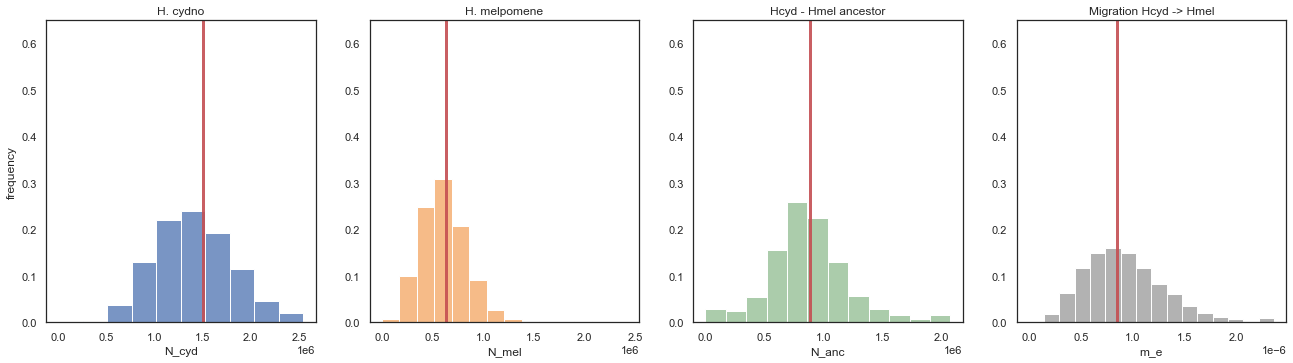

In [92]:
sns.set_theme(style="white")
fig, axs = plt.subplots(ncols = 4, figsize=(1600*px, 400*px))
#sns.histplot(data = lik_best_pd_bren, ax=axs[1], x = 'me', color = '0.6', binrange = (0,1.8e-6), binwidth = 3.49e-8, stat = 'probability').set(title='Effective migration Bino -> Bdaphne'))
sns.histplot(data = lik_best_pd_heli, ax=axs[0], color = 'b', x = 'Ne_A', binrange = (0,2300000), binwidth = 254545.4, stat = 'probability').set(title='H. cydno')
sns.histplot(data = lik_best_pd_heli, ax=axs[1], color = 'sandybrown', x = 'Ne_B', binrange = (0,2300000), binwidth =172727.2, stat = 'probability').set(title='H. melpomene')
sns.histplot(data = lik_best_pd_heli, ax=axs[2], color = 'darkseagreen', x = 'Ne_A_B', binrange = (0,2000000), binwidth = 172726, stat = 'probability').set(title='Hcyd - Hmel ancestor')
sns.histplot(data = lik_best_pd_heli, ax=axs[3], x = 'me', color = '0.6', binrange = (0,2.21e-6), binwidth = 1.47333332e-07, stat = 'probability').set(title='Migration Hcyd -> Hmel')
axs[0].axvline(x = mean_Ncyd, linewidth=3, alpha=0.9, color ='r')
axs[1].axvline(x = mean_Nmel, linewidth=3, alpha=0.9, color ='r')
axs[2].axvline(x = mean_Nanc, linewidth=3, alpha=0.9, color ='r')
axs[3].axvline(x = mean_me_heli, linewidth=3, alpha=0.9, color ='r')
axs[0].set_ylim(0,0.65)
axs[1].set_ylim(0,0.65)
axs[2].set_ylim(0,0.65)
axs[3].set_ylim(0,0.65)
axs[0].set_ylabel('frequency')
axs[1].set_ylabel(None)
axs[2].set_ylabel(None)
axs[3].set_ylabel(None)
axs[0].set_xlabel('N_cyd')
axs[1].set_xlabel('N_mel')
axs[2].set_xlabel('N_anc')
axs[3].set_xlabel('m_e')
plt.savefig("figures/best_Heli_hist_all.png")
plt.savefig("figures/best_Heli_hist_all.tiff")
plt.show()

In comparison, simulating data without any heterogeneity (under the best fitting global model) gives much tighter local estimates:

In [53]:
lik_best_f_sim = "laetsch_et_al_2023_data/heliconius.v1.gridsearch_IM_BA_sims_1rep_IM_BA_final_0.best.bed"
lik_best_pd_sim = pd.read_csv(lik_best_f_sim, sep = '\t', header =1);
lik_best_pd_sim.columns = [col.lstrip("#").strip() for col in lik_best_pd_sim.columns]

In [54]:
mean_me_sim = lik_best_pd_sim['me'].to_numpy(dtype = 'float64').mean()
mean_Ncyd_sim = lik_best_pd_sim['Ne_A'].to_numpy(dtype = 'float64').mean()
mean_Nmel_sim = lik_best_pd_sim['Ne_B'].to_numpy(dtype = 'float64').mean()
mean_Nanc_sim = lik_best_pd_sim['Ne_A_B'].to_numpy(dtype = 'float64').mean()
print(np.array([mean_me_sim, mean_Ncyd_sim, mean_Nmel_sim, mean_Nanc_sim]).round(decimals=10))

[5.39000000e-07 1.64930017e+06 7.33718301e+05 2.24067365e+05]


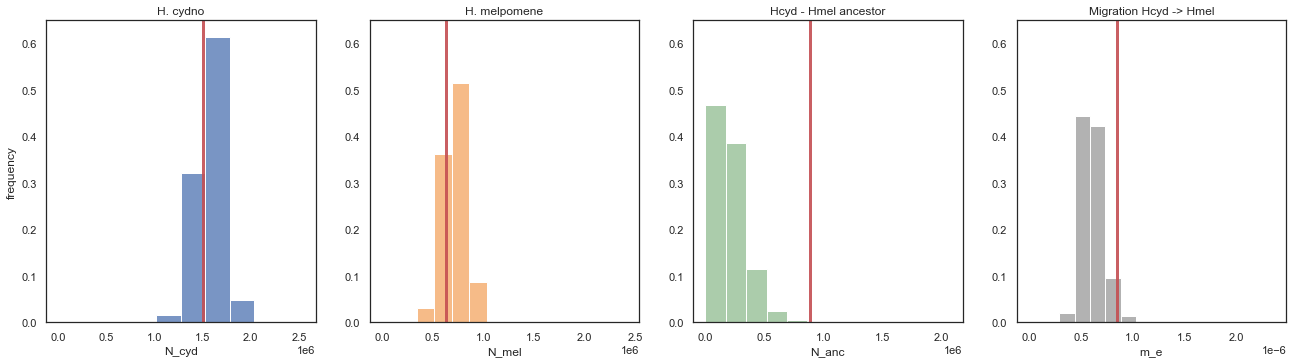

In [93]:
sns.set_theme(style="white")
fig, axs = plt.subplots(ncols = 4, figsize=(1600*px, 400*px))
#sns.histplot(data = lik_best_pd_bren, ax=axs[1], x = 'me', color = '0.6', binrange = (0,1.8e-6), binwidth = 3.49e-8, stat = 'probability').set(title='Effective migration Bino -> Bdaphne'))
sns.histplot(data = lik_best_pd_sim, ax=axs[0], color = 'b', x = 'Ne_A', binrange = (0,2300000), binwidth = 254545.4, stat = 'probability').set(title='H. cydno')
sns.histplot(data = lik_best_pd_sim, ax=axs[1], color = 'sandybrown', x = 'Ne_B', binrange = (0,2300000), binwidth =172727.2, stat = 'probability').set(title='H. melpomene')
sns.histplot(data = lik_best_pd_sim, ax=axs[2], color = 'darkseagreen', x = 'Ne_A_B', binrange = (0,2000000), binwidth = 172726, stat = 'probability').set(title='Hcyd - Hmel ancestor')
sns.histplot(data = lik_best_pd_sim, ax=axs[3], x = 'me', color = '0.6', binrange = (0,2.21e-6), binwidth = 1.47333332e-07, stat = 'probability').set(title='Migration Hcyd -> Hmel')
axs[0].axvline(x = mean_Ncyd, linewidth=3, alpha=0.9, color ='r')
axs[1].axvline(x = mean_Nmel, linewidth=3, alpha=0.9, color ='r')
axs[2].axvline(x = mean_Nanc, linewidth=3, alpha=0.9, color ='r')
axs[3].axvline(x = mean_me_heli, linewidth=3, alpha=0.9, color ='r')
axs[0].set_ylim(0,0.65)
axs[1].set_ylim(0,0.65)
axs[2].set_ylim(0,0.65)
axs[3].set_ylim(0,0.65)
axs[0].set_ylabel('frequency')
axs[1].set_ylabel(None)
axs[2].set_ylabel(None)
axs[3].set_ylabel(None)
axs[0].set_xlabel('N_cyd')
axs[1].set_xlabel('N_mel')
axs[2].set_xlabel('N_anc')
axs[3].set_xlabel('m_e')
plt.savefig("figures/best_Heli_hist_sim.png")
plt.savefig("figures/best_Heli_hist_sim.tiff")
plt.show()

The best supported parameter estimates under the MIG model are:

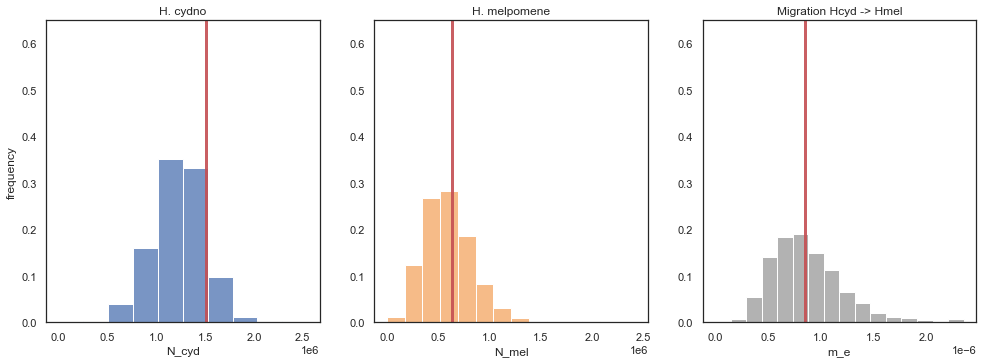

In [94]:
sns.set_theme(style="white")
fig, axs = plt.subplots(ncols = 3, figsize=(1200*px, 400*px))
#sns.histplot(data = lik_best_pd_bren, ax=axs[1], x = 'me', color = '0.6', binrange = (0,1.8e-6), binwidth = 3.49e-8, stat = 'probability').set(title='Effective migration Bino -> Bdaphne'))
sns.histplot(data = lik_mig_pd_heli, ax=axs[0], color = 'b', x = 'Ne_A', binrange = (0,2300000), binwidth = 254545.4, stat = 'probability').set(title='H. cydno')
sns.histplot(data = lik_mig_pd_heli, ax=axs[1], color = 'sandybrown', x = 'Ne_B', binrange = (0,2300000), binwidth =172727.2, stat = 'probability').set(title='H. melpomene')
sns.histplot(data = lik_mig_pd_heli, ax=axs[2], x = 'me', color = '0.6', binrange = (0,2.21e-6), binwidth = 1.47333332e-07, stat = 'probability').set(title='Migration Hcyd -> Hmel')
axs[0].axvline(x = mean_Ncyd, linewidth=3, alpha=0.9, color ='r')
axs[1].axvline(x = mean_Nmel, linewidth=3, alpha=0.9, color ='r')
axs[2].axvline(x = mean_me_heli, linewidth=3, alpha=0.9, color ='r')
axs[0].set_ylim(0,0.65)
axs[1].set_ylim(0,0.65)
axs[2].set_ylim(0,0.65)
axs[0].set_ylabel('frequency')
axs[1].set_ylabel(None)
axs[2].set_ylabel(None)
axs[0].set_xlabel('N_cyd')
axs[1].set_xlabel('N_mel')
axs[2].set_xlabel('m_e')
plt.savefig("figures/mig_Heli_hist_all.png")
plt.savefig("figures/mig_Heli_hist_all.tiff")
plt.show()

# gIMble scans of the Heliconius genome

## Computing $\Delta B$: slicing gIMble likelihoods

This imports the window-wise slice of $\ln CL$ (maximising support for the three $N_e$ parameters) values in the (gridded) $m_e$ direction:

In [95]:
lik_slice1_f= 'laetsch_et_al_2023_dataa/heliconius.v1.gridsearch_windows_IM_BA_final_0.sliced_param.me.bed';
lik_slice1_pd= pd.read_csv(lik_slice1_f, sep = '\t', header =1);
lik_slice1_pd.columns = [col.lstrip("#").strip() for col in lik_slice1_pd.columns]

In [96]:
lik_mig_slice1_f= 'laetsch_et_al_2023_data/heliconius.v1.gridsearch_windows_MIG_BA_0.sliced_param.me.bed';
lik_mig_slice1_pd= pd.read_csv(lik_mig_slice1_f, sep = '\t', header =1);
lik_mig_slice1_pd.columns = [col.lstrip("#").strip() for col in lik_mig_slice1_pd.columns]

From the above we can compute the difference in support for any model defined in terms of $m_e$ constrains. We are interested in $\Delta B_0$, the support for a model of no gene flow relative to the background model. This strips the first four columns and asignes the $m_e$ values that define the grid to a list:

In [97]:
me_list = []
for i in list(lik_slice1_pd.columns)[4:]:
    me_list.append(float(i.strip('me=')))
bg_me = me_list[5]
bg_me

7.366666666666667e-07

The maximum likelihood estimate for $m_e$ (given the grid) across marginal (windowise) lnCLs is given by:

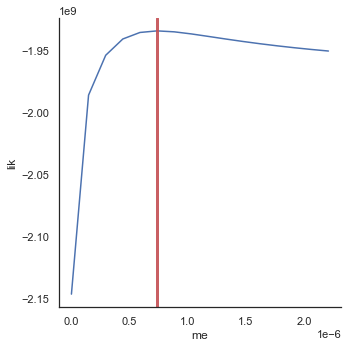

In [98]:
lik_np = lik_slice1_pd.to_numpy()[0:,4:]
sumlik = lik_np.sum(axis = 0);
df1 = pd.DataFrame(dict(me = me_list, lik = sumlik))
sns.relplot(x="me", y="lik", kind="line", data=df1)
plt.axvline(x = bg_me, linewidth=3, alpha=0.9, color ='r')
plt.show()

Below, I compute $\Delta B_0$ and  $\Delta B_{0.2}$:

In [99]:
backglnCLs = lik_np[0:,5];
barrierlnCLs0 = np.amax(lik_np[0:,0:1], axis = 1)
barrierlnCLs02 = np.amax(lik_np[0:,0:2], axis = 1)

In [100]:
deltaB0 = barrierlnCLs0 -backglnCLs
deltaB02 = barrierlnCLs02 -backglnCLs

In [101]:
wins_500_df['deltaB0'] = deltaB0;
wins_500_df['deltaB02'] = deltaB02;

In [107]:
print((wins_500_df['deltaB0'] >0).sum())
print((wins_500_df['deltaB02'] >0).sum())
print(len(wins_500_df))

87
871
11217


We add a column to wins_500_df indicating which windows are barriers

In [108]:
wins_500_df['∆B0 barrier'] = wins_500_df['deltaB0'] > 0
wins_500_df['∆B02 barrier'] = wins_500_df['deltaB02'] > 0

In [110]:
# I define the analogous Fst tail, i.e. the quantiles of F_st given by deltaB0 and deltaB02
quantile95_fst = [] 
for i in btiles:
    quantile95_fst.append(wins_500_df['f_st'].quantile(1-i))
quantile95_fst

[0.4963608531692966, 0.31003164749933143]

We also want to mark any gIMble window that overlaps the three known barrier genes on chromsomes 10, 15 and 18:

In [112]:
def test_wind(df, l, offset = 100_000):
    boolian1 = (df['sequence'] == l[0]) & ((l[1]-offset) < df['start']) & ((l[2]+offset) > df['start'])
    boolian2 = (df['sequence'] == l[0]) & ((l[1]-offset) < df['end']) & ((l[2]+offset) > df['end'])
    return np.logical_or(boolian1, boolian2)

In [113]:
chrom10 = test_wind(wins_500_df, wingenes[0]) 
chrom15 = test_wind(wins_500_df, wingenes[1])
chrom18 = test_wind(wins_500_df, wingenes[2])
allgenes = np.any(np.array([chrom10, chrom15, chrom18]), axis = 0);
wins_500_df['known_barriers'] = allgenes;

Five of the windows overlapping known barriers genes are ∆B0 barriers (compared to three windows that are in the anlogous $F_{ST}$ tail):

In [114]:
true_pos = wins_500_df[wins_500_df['known_barriers']];
print([len(true_pos), true_pos['∆B0 barrier'].sum(), (true_pos['f_st'] >quantile95_fst[0]).sum()])
print([len(true_pos), true_pos['∆B02 barrier'].sum(), (true_pos['f_st'] >quantile95_fst[1]).sum()])

[47, 5, 3]
[47, 28, 28]


Analogous measures of barrier support under the MIG model:

The fraction of $\Delta B_0$ and $\Delta B_{0.2}$ outlier windows is:

In [109]:
B1tile = (wins_500_df['deltaB0'] >0).sum()/len(wins_500_df)
B2tile = (wins_500_df['deltaB02'] >0).sum()/len(wins_500_df)
btiles = [B1tile,B2tile]

In [102]:
me_mig_list = []
for i in list(lik_mig_slice1_pd.columns)[4:]:
    me_mig_list.append(float(i.strip('me=')))
bg_mig_me = me_list[5]

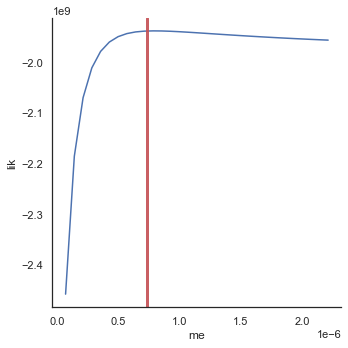

In [103]:
lik_mig_np = lik_mig_slice1_pd.to_numpy()[0:,4:]
sumlik_mig = lik_mig_np.sum(axis = 0)[1:];
df_mig = pd.DataFrame(dict(me = me_mig_list[1:], lik = sumlik_mig))
sns.relplot(x="me", y="lik", kind="line", data=df_mig)
plt.axvline(x = bg_me, linewidth=3, alpha=0.9, color ='r')
plt.show()

In [104]:
me_mig_list[4]

2.8516129032266774e-07

In [105]:
backglnCLsMIG = lik_mig_np[0:,10];
barrierlnCLs02MIG = np.amax(lik_mig_np[0:,0:4], axis = 1)

In [106]:
deltaB02MIG = barrierlnCLs02MIG -backglnCLsMIG
wins_500_df['deltaB02MIG'] = deltaB02MIG;

## Plotting $\Delta lnCL$

In [134]:
def parse_slices(path, files, df, B_def):
	background_indices = []
	for i, f in enumerate(files):
		slice_df = pd.read_csv(path+"/"+f, sep="\t", header = 1)
		lik_np_sim = slice_df.to_numpy()[0:,3:]
		sum_lik_np_sim = lik_np_sim.sum(axis=0)
		background_me_idx = np.where(sum_lik_np_sim==sum_lik_np_sim.max())[0][0]
		background_indices.append(background_me_idx)
		background_column = slice_df.columns.to_list()[3+background_me_idx]
		df[i] = np.amax(lik_np_sim[0:,0:B_def+1], axis = 1)- slice_df[background_column]
	print("Best fitting background m_e gridpoint per replicate:")
	print(background_indices)

In [116]:
def calculate_fpr(df):
	return pd.DataFrame(df>0).sum(axis=1)/df.shape[1]

def calc_thresh(percentile,df,k):
	df = df.iloc[:,k:100+k]
	return	df.apply(lambda row: row.nlargest(percentile).values[percentile-1],axis=1)

The $m_e$ marginal likelihood slice for 100 bootstrap replicates is contained in the folder bootstrap_replicates. A compressed version of this is available via data dryad (DOI: 10.5061/dryad.4j0zpc8jc).

In [135]:
upper_percentile = 5
sim_folder = 'bootstrap_replicates'
obs_deltab0_f = 'laetsch_et_al_2023_data/obs_deltab0.txt'
obs_deltab02_f = 'laetsch_et_al_2023_data/obs_deltab02.txt'
files = [file for file in os.listdir(sim_folder) if not file.startswith('.')]
deltab0_df = pd.read_csv(obs_deltab0_f, header=None, names=[sim_folder])
deltab02_df = pd.read_csv(obs_deltab02_f, header=None, names=[sim_folder])

The best fitting background $m_e$ values for all 100 replicates is underestimated, i.e. the 4th (rather than 5th) value in the grid, i.e. 5.893333333333333e-07:

In [136]:
parse_slices(path=sim_folder, files=files, df=deltab0_df, B_def=0)
deltab0_df['fpr'] = calculate_fpr(deltab0_df[range(len(files))])

Best fitting background m_e gridpoint per replicate:
[4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4]


In [119]:
me_list[4]

5.893333333333333e-07

In [137]:
parse_slices(path=sim_folder, files=files, df=deltab02_df, B_def=1)
deltab02_df['fpr'] = calculate_fpr(deltab02_df[range(len(files))])

Best fitting background m_e gridpoint per replicate:
[4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4]


In [138]:
wins_500_df['fprB0'] = deltab0_df['fpr']
wins_500_df['fprB02'] = deltab02_df['fpr']

The overal FPR is much lower than the fraction of barrier windows:

In [139]:
print('Overal FPR:', wins_500_df['fprB0'].mean())
print('FPR at barriers:',wins_500_df[wins_500_df['deltaB0']>0]['fprB0'].mean())

Overal FPR: 0.00020058839261834715
FPR at barriers: 0.005172413793103449


In [140]:
print('Overal FPR:', wins_500_df['fprB02'].mean())
print('FPR at barriers:',wins_500_df[wins_500_df['deltaB02']>0]['fprB02'].mean())

Overal FPR: 0.004452170812160114
FPR at barriers: 0.03152698048220436


In [141]:
wins_500_df['deltab0_threshold'] = calc_thresh(5, deltab0_df, 1)
wins_500_df['deltab02_threshold']  = calc_thresh(5, deltab02_df, 1)
wins_500_df['False positive rate B0'] = np.where(wins_500_df['fprB0'] <= 0.01, 'FPR ≤ 0.01',  np.where(wins_500_df['fprB0'] <= 0.02,'FPR ≤ 0.02', np.where(wins_500_df['fprB0'] <= 0.05, 'FPR ≤ 0.05', 'FPR > 0.05')))
wins_500_df['False positive rate B02'] = np.where(wins_500_df['fprB02'] <= 0.01, 'FPR ≤ 0.01',  np.where(wins_500_df['fprB02'] <= 0.02,'FPR ≤ 0.02', np.where(wins_500_df['fprB0'] <= 0.05, 'FPR ≤ 0.05', 'FPR > 0.05')))

In [142]:
def get_coordinates(genome_f):
    genome_df = pd.read_csv(genome_f, sep="\t", usecols=[0,1], names=['sequence_id', 'sequence_length'], dtype={'sequence_id': 'category', 'sequence_length': 'int64'}, header=None)
    # change sequence names ...
    genome_df['sequence_id'] = genome_df['sequence_id'].str.replace('hmel2_5.','').str.replace('chr0','chr')
    offset_by_sequence_id = {}
    offset = 0
    bg_rectangles = []
    for idx, (sequence_id, sequence_length) in enumerate(list(genome_df.itertuples(index=False, name=None))):
        offset_by_sequence_id[sequence_id] = offset
        bg_rectangles.append((sequence_id, offset, offset + sequence_length))
        offset += sequence_length
    return (offset_by_sequence_id, bg_rectangles)

def get_highlights():
    pass
    
genome_f = "laetsch_et_al_2023_data/gimble.autosomes.genomefile"
offset_by_sequence_id, bg_rectangles = get_coordinates(genome_f)
genome_df = pd.read_csv(genome_f, sep="\t", usecols=[0,1], names=['sequence_id', 'sequence_length'], dtype={'sequence_id': 'category', 'sequence_length': 'int64'}, header=None)

In [145]:
def plot_popgen_scan_all(wins_500_df, offset_by_sequence_id, bg_rectangles, column, hue_column, out_prefix, y_min=None):
    palette ={"FPR ≤ 0.01": "C0", "FPR ≤ 0.02": "C1", 'FPR ≤ 0.05': "C2", 'FPR > 0.05': "C3"}
    hue_order = ["FPR ≤ 0.01", "FPR ≤ 0.02", 'FPR ≤ 0.05','FPR > 0.05']
    fig, axs = plt.subplots(nrows=2, figsize=(1800*px, 400*px), sharey=False, sharex=True, gridspec_kw={'height_ratios': [1, 20]})
    xticks = []
    xtick_labels = []
    ax_top = axs[0]
    ax_scan = axs[1]
    if offset_by_sequence_id and bg_rectangles:
        wins_500_df['x'] = wins_500_df['pos_mean'] + wins_500_df['sequence'].map(offset_by_sequence_id)
        for idx, (sequence_id, axvspan_min, axvspan_max) in enumerate(bg_rectangles):
            if idx % 2 != 0: # only make rectangles for every 2nd one
                ax_scan.axvspan(axvspan_min, axvspan_max, color='whitesmoke', zorder=-1)
                ax_top.axvspan(axvspan_min, axvspan_max, color='whitesmoke', zorder=-1)
            xticks.append(axvspan_min+(axvspan_max - axvspan_min)/2)
            xtick_labels.append(sequence_id)
        xlabel="chromosome"
    else:
        wins_500_df['x'] = wins_500_df['pos_mean']
        xlabel=wins_500_df["sequence"].unique()[0]
    wins_500_df['outlier'] = np.where(wins_500_df[column] >= 0, True, False)
    # ax_top
    for i, group in wins_500_df.groupby([(wins_500_df.outlier != wins_500_df.outlier.shift()).cumsum()]):
        if group.outlier.all():
            ax_top.axvspan(group.x.min(), group.x.max(), color='red', zorder=1)
    # dots
    ax_scan = sns.scatterplot(data=wins_500_df, x="x",  y= column, color='black', s=1)
    # lines
    ax_scan = sns.lineplot(data=wins_500_df, x="x",  y= "deltab02_threshold", color='silver', alpha=0.8, lw=1)
    ax_scan = sns.lineplot(data=wins_500_df, x="x",  y= column, color='black', alpha=0.8, lw=0.3)
    
    # outliers
    #hue_order = hue_order
    ax_scan = sns.scatterplot(data=wins_500_df[wins_500_df[column]>0], x="x",  y=column, hue = hue_column, hue_order = hue_order, palette=palette, s=20)
    # xticks
    ax_scan.set_xticks(xticks)
    ax_scan.set_xticklabels(xtick_labels, rotation=45)
    ax_scan.set_xlabel(xlabel)
    ax_top.set_yticks([])
    ax_top.set_ylabel('barriers', rotation=0, horizontalalignment='right', verticalalignment='center')
    plt.ylim(y_min, 20000)
    plt.axhline(y = 0, linewidth=3, ls = '--', lw=1, alpha=0.9, color ='black')
    plt.tight_layout()
    out_ff = '%s.tiff' % out_prefix
    out_f = '%s.png' % out_prefix
    fig.savefig(out_ff)
    fig.savefig(out_f)
    #plt.close(fig)

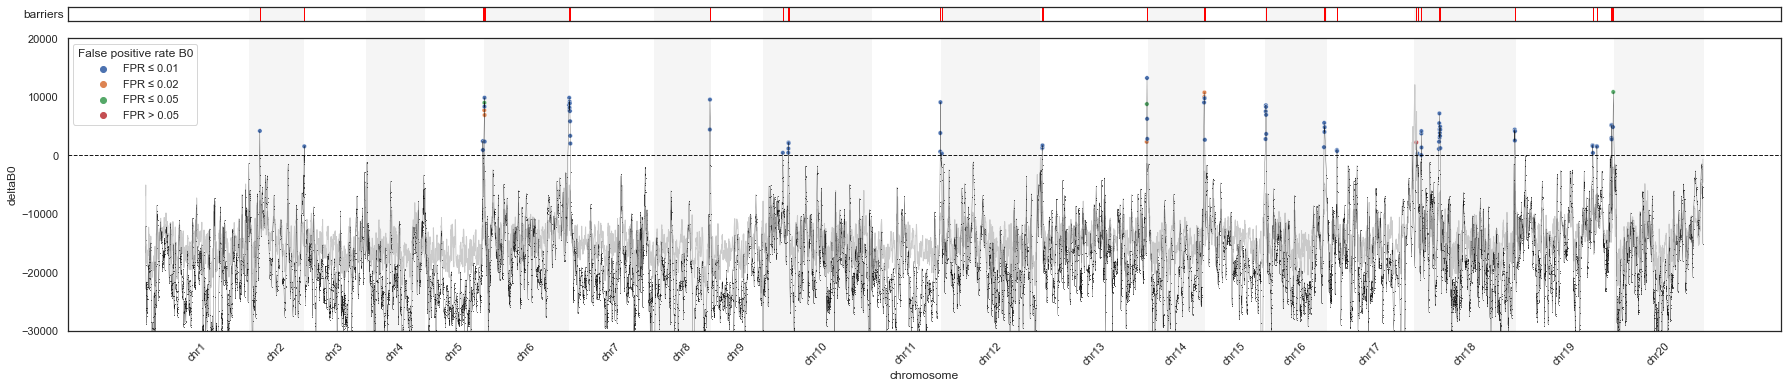

In [144]:
plot_popgen_scan_all(wins_500_df, offset_by_sequence_id, bg_rectangles, "deltaB0", "False positive rate B0", "figures/deltaB0_scan_heli",y_min=-30000)

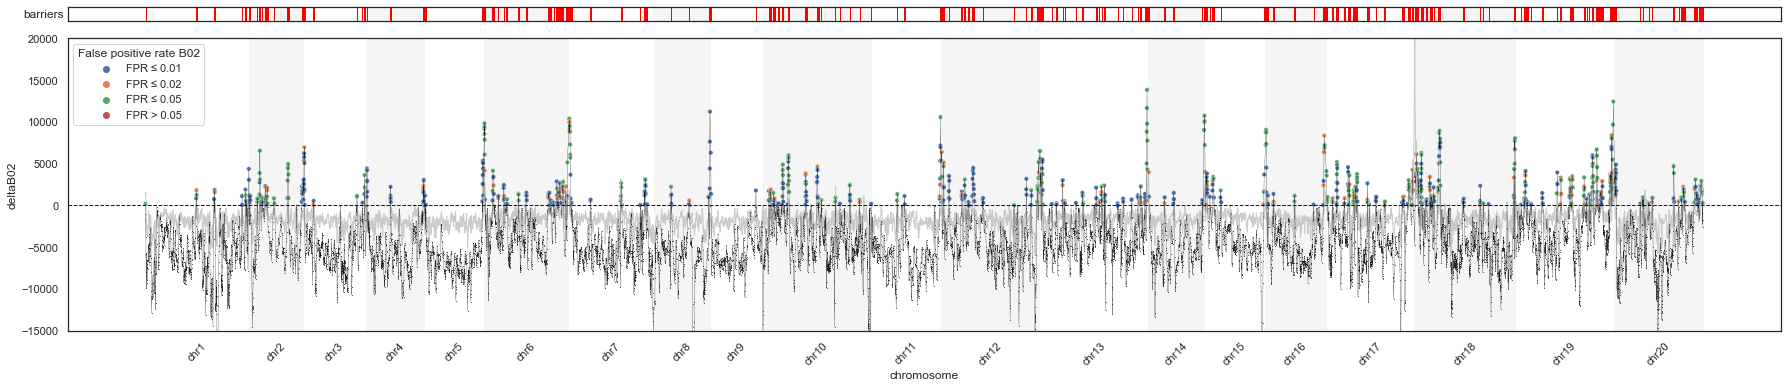

In [146]:
plot_popgen_scan_all(wins_500_df, offset_by_sequence_id, bg_rectangles, "deltaB02", "False positive rate B02", "figures/deltaB02_scan_heli",y_min=-15000)

# Zooming in on candidate chromosomes

This imports the predicted $m_e$ from Simon Aeschbacher's model:

In [147]:
simon_me_df = pd.read_csv('laetsch_et_al_2023_data/64bpX500blocks-rho-cds-sumstats-me-fit-range-comb.tsv', sep='\t')
wins_500_df['Aesch'] = simon_me_df['me_cyd..mel_fit_w_cds_r1000_cds250']

In [157]:
from matplotlib.patches import Rectangle

def plot_m_e_scan_chrom(wins_500_df, out_prefix, candidate_coord=None, y_min1=None, y_min2=None):
    wins_500_df['x'] = wins_500_df['pos_mean']
    x_max = wins_500_df['x'].iloc[-1]
    fig, axs = plt.subplots(nrows=3, figsize=((x_max/20_000_000)*1_000*px,300*px), sharey=False, sharex=True, gridspec_kw={'height_ratios': [2, 20, 20]})
    xticks = np.arange(0, 20_000_000, 2_000_000)
    xtick_labels = np.arange(0, 20, 2)
    ax_top = axs[0]
    ax_scan_me = axs[1]
    ax_scan_Delta = axs[2]
    
    rect01 = Rectangle((candidate_coord[0]-100_000, y_min1[0]), candidate_coord[1]-candidate_coord[0]+200_000, y_min1[1]-y_min1[0], linewidth=1, edgecolor='lightsteelblue',facecolor='lightsteelblue')
    rect02 = Rectangle((candidate_coord[0]-100_000, y_min2[0]), candidate_coord[1]-candidate_coord[0]+200_000, y_min2[1]-y_min2[0], linewidth=1, edgecolor='lightsteelblue',facecolor='lightsteelblue')
    ax_scan_me.add_patch(rect01)
    ax_scan_Delta.add_patch(rect02)
    rect11 = Rectangle((candidate_coord[0], y_min1[0]), candidate_coord[1]-candidate_coord[0], y_min1[1]-y_min1[0], linewidth=1, edgecolor='steelblue',facecolor='steelblue')
    rect12 = Rectangle((candidate_coord[0], y_min2[0]), candidate_coord[1]-candidate_coord[0], y_min2[1]-y_min2[0], linewidth=1, edgecolor='steelblue',facecolor='steelblue')
    ax_scan_me.add_patch(rect11)
    ax_scan_Delta.add_patch(rect12)
    
    # extra rectangles for magic trait locus on chrom 18, comment out when plotting other chroms!!
    grik2 = [334856, 345144]
    grik11 = Rectangle((grik2[0], y_min1[0]),grik2[1]-grik2[0], y_min1[1]-y_min1[0], linewidth=1, edgecolor='chocolate',facecolor='brown')
    grik12 = Rectangle((grik2[0], y_min2[0]),grik2[1]-grik2[0], y_min2[1]-y_min2[0], linewidth=1, edgecolor='chocolate',facecolor='brown') 
    
    grik21 = Rectangle((grik2[0]-100_000, y_min1[0]), grik2[1]-grik2[0]+200_000, y_min1[1]-y_min1[0], linewidth=1, edgecolor='burlywood',facecolor='burlywood')
    grik22 = Rectangle((grik2[0]-100_000, y_min2[0]), grik2[1]-grik2[0]+200_000, y_min2[1]-y_min2[0], linewidth=1, edgecolor='burlywood',facecolor='burlywood')
    ax_scan_me.add_patch(grik21)
    ax_scan_Delta.add_patch(grik22)
    ax_scan_me.add_patch(grik11)
    ax_scan_Delta.add_patch(grik12)
    
    regucalcin = [535_000, 542_000]
    rect31 = Rectangle((regucalcin[0]-100_000, y_min1[0]), regucalcin[1]-regucalcin[0]+200_000, y_min1[1]-y_min1[0], linewidth=1, edgecolor='burlywood',facecolor='burlywood')
    rect32 = Rectangle((regucalcin[0]-100_000, y_min2[0]), regucalcin[1]-regucalcin[0]+200_000, y_min2[1]-y_min2[0], linewidth=1, edgecolor='burlywood',facecolor='burlywood')

    ax_scan_me.add_patch(rect31)
    ax_scan_Delta.add_patch(rect32)
    rect41 = Rectangle((regucalcin[0], y_min1[0]),regucalcin[1]-regucalcin[0], y_min1[1]-y_min1[0], linewidth=1, edgecolor='chocolate',facecolor='brown')
    rect42 = Rectangle((regucalcin[0], y_min2[0]),regucalcin[1]-regucalcin[0], y_min2[1]-y_min2[0], linewidth=1, edgecolor='chocolate',facecolor='brown') 
    ax_scan_me.add_patch(rect41)
    ax_scan_Delta.add_patch(rect42)
    
    xlabel = 'Mb'
    #wins_500_df["sequence"].unique()[0]''
    wins_500_df['outlier'] = np.where(wins_500_df['deltaB0'] >= 0 , True, False)
    # ax_top
    for i, group in wins_500_df.groupby([(wins_500_df.outlier != wins_500_df.outlier.shift()).cumsum()]):
        if group.outlier.all():
            ax_top.axvspan(group.x.min(), group.x.max(), color='red', zorder=-1)
    # dots
    sns.scatterplot(data=wins_500_df, x="x", ax = ax_scan_me, y= 'me', color='black', s=0.5)
    # lines
    sns.lineplot(data=wins_500_df, x="x", ax = ax_scan_me, y= 'me', color='black', alpha=0.9, lw=0.45)
    sns.lineplot(data=wins_500_df, x="x", ax = ax_scan_me, y= 'Aesch', color='green', alpha=0.9, lw=1)
    
    # dots
    sns.scatterplot(data=wins_500_df, x="x", y='deltaB0', ax = ax_scan_Delta, color='black', s=0.5)
    # lines
    sns.lineplot(data=wins_500_df, x="x", y='deltaB0', ax = ax_scan_Delta, color='black', alpha=0.9, lw=0.45)
    # outliers
    sns.scatterplot(data=wins_500_df[wins_500_df['deltaB0']>0], x="x",  y='deltaB0' , color='red', s=5)
    
    # xticks
    ax_scan_me.set_xticks(xticks)
    ax_scan_me.set_xticklabels(xtick_labels, rotation=0)
    ax_scan_me.set_xlabel(xlabel)
    ax_scan_Delta.set_xticks(xticks)
    ax_scan_Delta.set_xticklabels(xtick_labels, rotation=0)
    ax_scan_Delta.set_xlabel(xlabel)
    # change manually to match chromosome
    ax_top.set_title('Chromosome 18')
    ax_top.set_yticks([])
    ax_top.set_ylabel('barriers', rotation=0, horizontalalignment='right', verticalalignment='center')
    ax_scan_me.set_ylabel('m_e', rotation=90, horizontalalignment='right', verticalalignment='bottom')
    ax_scan_me.axhline(y = bg_me, lw=2, ls = 'dotted', alpha=1, color ='gray')
    ax_scan_Delta.set_ylabel('∆B0', rotation=90, horizontalalignment='right', verticalalignment='top')
    ax_scan_me.set_ylim(y_min1[0], y_min1[1])
    ax_scan_Delta.set_ylim(y_min2[0], y_min2[1])
    plt.xlim(0, x_max)
    #plt.show()
    plt.axhline(y = 0, linewidth=3, ls = '--', lw=1, alpha=0.9, color ='black')
    plt.tight_layout()
    out_ff = '%s.tiff' % out_prefix
    out_f = '%s.png' % out_prefix
    fig.savefig(out_ff)
    fig.savefig(out_f)

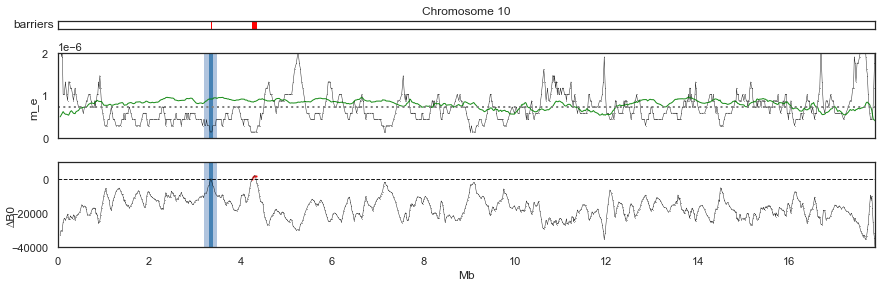

In [153]:
plot_m_e_scan_chrom(wins_500_df[wins_500_df['sequence']=="chr10"], "figures/chrom10", wingenes[0][1:], [0, 2e-6],[-40_000, 10_000])

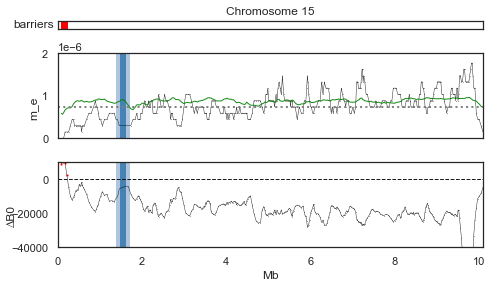

In [156]:
plot_m_e_scan_chrom(wins_500_df[wins_500_df['sequence']=="chr15"], "figures/chrom15", wingenes[1][1:], [0, 2e-6],[-40_000, 10_000])

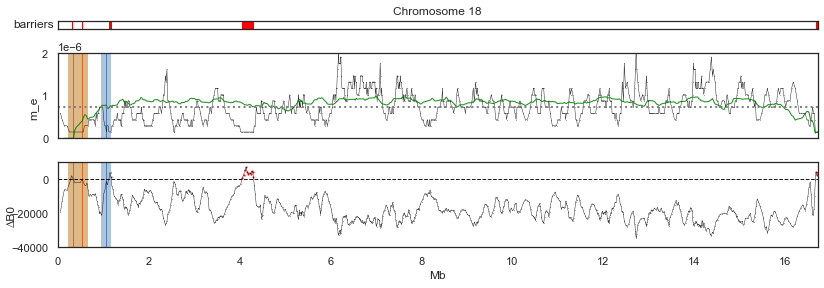

In [158]:
plot_m_e_scan_chrom(wins_500_df[wins_500_df['sequence']=="chr18"], "figures/chrom18", wingenes[2][1:], [0, 2e-6],[-40_000, 10_000])

In [167]:
def plot_m_e_scan_chrom(wins_500_df, out_prefix, candidate_coord=None, y_min1=None, y_min2=None):
    wins_500_df['x'] = wins_500_df['pos_mean']
    x_max = wins_500_df['x'].iloc[-1]
    fig, axs = plt.subplots(nrows=3, figsize=((x_max/20_000_000)*1_000*px,300*px), sharey=False, sharex=True, gridspec_kw={'height_ratios': [2, 20, 20]})
    xticks = np.arange(0, 20_000_000, 2_000_000)
    xtick_labels = np.arange(0, 20, 2)
    ax_top = axs[0]
    ax_scan_me = axs[1]
    ax_scan_Delta = axs[2]
    
    rect01 = Rectangle((candidate_coord[0]-100_000, y_min1[0]), candidate_coord[1]-candidate_coord[0]+200_000, y_min1[1]-y_min1[0], linewidth=1, edgecolor='lightsteelblue',facecolor='lightsteelblue')
    rect02 = Rectangle((candidate_coord[0]-100_000, y_min2[0]), candidate_coord[1]-candidate_coord[0]+200_000, y_min2[1]-y_min2[0], linewidth=1, edgecolor='lightsteelblue',facecolor='lightsteelblue')
    ax_scan_me.add_patch(rect01)
    ax_scan_Delta.add_patch(rect02)
    rect11 = Rectangle((candidate_coord[0], y_min1[0]), candidate_coord[1]-candidate_coord[0], y_min1[1]-y_min1[0], linewidth=1, edgecolor='steelblue',facecolor='steelblue')
    rect12 = Rectangle((candidate_coord[0], y_min2[0]), candidate_coord[1]-candidate_coord[0], y_min2[1]-y_min2[0], linewidth=1, edgecolor='steelblue',facecolor='steelblue')
    ax_scan_me.add_patch(rect11)
    ax_scan_Delta.add_patch(rect12)
    
   # extra rectangles for magic trait locus on chrom 18, comment out when plotting other chroms!!
    grik2 = [334856, 345144]
    grik11 = Rectangle((grik2[0], y_min1[0]),grik2[1]-grik2[0], y_min1[1]-y_min1[0], linewidth=1, edgecolor='chocolate',facecolor='brown')
    grik12 = Rectangle((grik2[0], y_min2[0]),grik2[1]-grik2[0], y_min2[1]-y_min2[0], linewidth=1, edgecolor='chocolate',facecolor='brown') 
    
    grik21 = Rectangle((grik2[0]-100_000, y_min1[0]), grik2[1]-grik2[0]+200_000, y_min1[1]-y_min1[0], linewidth=1, edgecolor='burlywood',facecolor='burlywood')
    grik22 = Rectangle((grik2[0]-100_000, y_min2[0]), grik2[1]-grik2[0]+200_000, y_min2[1]-y_min2[0], linewidth=1, edgecolor='burlywood',facecolor='burlywood')
    ax_scan_me.add_patch(grik21)
    ax_scan_Delta.add_patch(grik22)
    ax_scan_me.add_patch(grik11)
    ax_scan_Delta.add_patch(grik12)
    
    regucalcin = [535_000, 542_000]
    rect31 = Rectangle((regucalcin[0]-100_000, y_min1[0]), regucalcin[1]-regucalcin[0]+200_000, y_min1[1]-y_min1[0], linewidth=1, edgecolor='burlywood',facecolor='burlywood')
    rect32 = Rectangle((regucalcin[0]-100_000, y_min2[0]), regucalcin[1]-regucalcin[0]+200_000, y_min2[1]-y_min2[0], linewidth=1, edgecolor='burlywood',facecolor='burlywood')

    ax_scan_me.add_patch(rect31)
    ax_scan_Delta.add_patch(rect32)
    rect41 = Rectangle((regucalcin[0], y_min1[0]),regucalcin[1]-regucalcin[0], y_min1[1]-y_min1[0], linewidth=1, edgecolor='chocolate',facecolor='brown')
    rect42 = Rectangle((regucalcin[0], y_min2[0]),regucalcin[1]-regucalcin[0], y_min2[1]-y_min2[0], linewidth=1, edgecolor='chocolate',facecolor='brown') 
    ax_scan_me.add_patch(rect41)
    ax_scan_Delta.add_patch(rect42)
    
    xlabel = 'Mb'
    wins_500_df['outlier'] = np.where(wins_500_df['deltaB02'] >= 0 , True, False)
    # ax_top
    for i, group in wins_500_df.groupby([(wins_500_df.outlier != wins_500_df.outlier.shift()).cumsum()]):
        if group.outlier.all():
            ax_top.axvspan(group.x.min(), group.x.max(), color='red', zorder=-1)
    # dots
    sns.scatterplot(data=wins_500_df, x="x", ax = ax_scan_me, y= 'me', color='black', s=0.5)
    sns.scatterplot(data=wins_500_df, x="x", ax = ax_scan_me, y= 'MIG_me', color='blue', s=0.5)
    # lines
    sns.lineplot(data=wins_500_df, x="x", ax = ax_scan_me, y= 'me', color='black', alpha=0.9, lw=0.45)
    sns.lineplot(data=wins_500_df, x="x", ax = ax_scan_me, y= 'MIG_me', color='blue', alpha=0.9, lw=0.45)
    sns.lineplot(data=wins_500_df, x="x", ax = ax_scan_me, y= 'Aesch', color='green', alpha=0.9, lw=1)
    
    # dots
    sns.scatterplot(data=wins_500_df, x="x", y='deltaB02', ax = ax_scan_Delta, color='black', s=0.5)
    sns.scatterplot(data=wins_500_df, x="x", y='deltaB02MIG', ax = ax_scan_Delta, color='blue', s=0.5)
    # lines
    sns.lineplot(data=wins_500_df, x="x", y='deltaB02', ax = ax_scan_Delta, color='black', alpha=0.9, lw=0.45)
    sns.lineplot(data=wins_500_df, x="x", y='deltaB02MIG', ax = ax_scan_Delta, color='blue', alpha=0.9, lw=0.45)
     # outliers
    sns.scatterplot(data=wins_500_df[wins_500_df['deltaB02']>0], x="x",  y='deltaB02' , color='red', s=5)
    
    # xticks
    ax_scan_me.set_xticks(xticks)
    ax_scan_me.set_xticklabels(xtick_labels, rotation=0)
    ax_scan_me.set_xlabel(xlabel)
    ax_scan_Delta.set_xticks(xticks)
    ax_scan_Delta.set_xticklabels(xtick_labels, rotation=0)
    ax_scan_Delta.set_xlabel(xlabel)
    # change manually to match chromosome:
    ax_top.set_title('Chromosome 18')
    ax_top.set_yticks([])
    ax_top.set_ylabel('barriers', rotation=0, horizontalalignment='right', verticalalignment='center')
    ax_scan_me.set_ylabel('m_e', rotation=90, horizontalalignment='right', verticalalignment='bottom')
    ax_scan_me.axhline(y = bg_me, lw=2, ls = 'dotted', alpha=1, color ='gray')
    ax_scan_Delta.set_ylabel('∆B02', rotation=90, horizontalalignment='right', verticalalignment='top')
    ax_scan_me.set_ylim(y_min1[0], y_min1[1])
    ax_scan_Delta.set_ylim(y_min2[0], y_min2[1])
    plt.xlim(0, x_max)
    plt.axhline(y = 0, linewidth=3, ls = '--', lw=1, alpha=0.9, color ='black')
    plt.tight_layout()
    out_ff = '%s.tiff' % out_prefix
    out_f = '%s.png' % out_prefix
    fig.savefig(out_ff)
    fig.savefig(out_f)

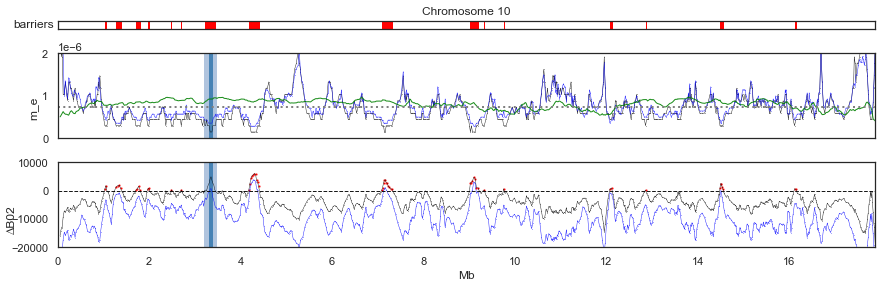

In [165]:
plot_m_e_scan_chrom(wins_500_df[wins_500_df['sequence']=="chr10"], "figures/chrom10_SUPPL", wingenes[0][1:], [0, 2e-6],[-20_000, 10_000])

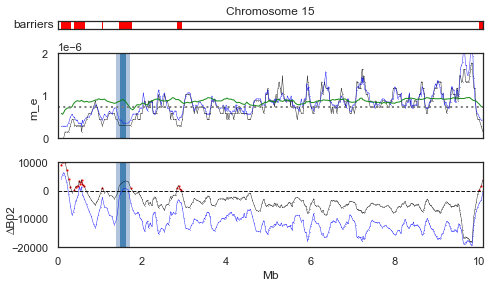

In [163]:
plot_m_e_scan_chrom(wins_500_df[wins_500_df['sequence']=="chr15"], "figures/chrom15_SUPPL", wingenes[1][1:], [0, 2e-6],[-20_000, 10_000])

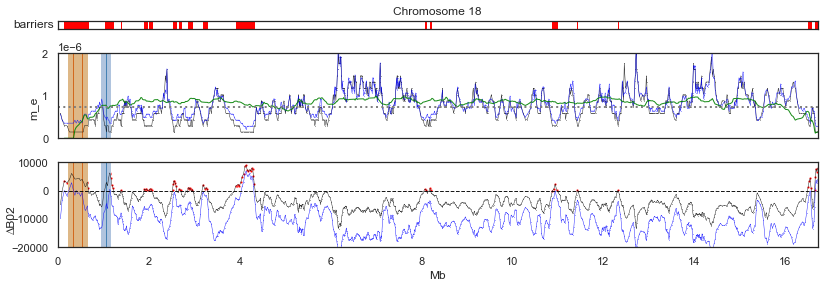

In [168]:
plot_m_e_scan_chrom(wins_500_df[wins_500_df['sequence']=="chr18"], "figures/chrom18_SUPPL", wingenes[2][1:], [0, 2e-6],[-20_000, 10_000])

## The correlates of $\Delta B$

### 1. Unsurprisingly $F_{ST}$ and $\Delta B_0$ are correlated:

In [169]:
print("The correlation between F_st and DeltaB0 is", pearsonr(wins_500_df["f_st"], wins_500_df["deltaB0"]))

The correlation between F_st and DeltaB0 is (0.7833405122097039, 0.0)


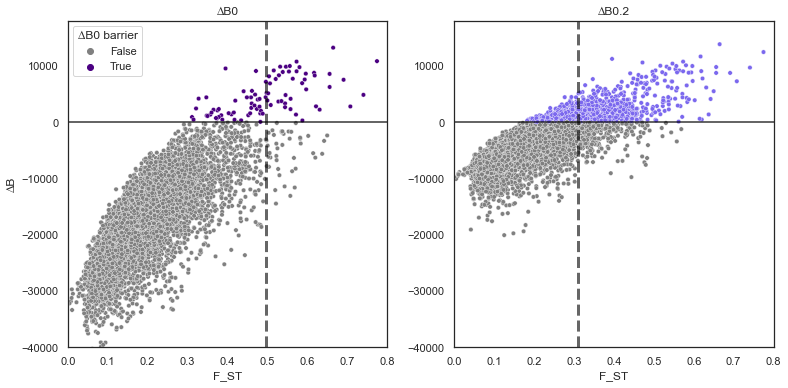

In [175]:
fig, axs = plt.subplots(ncols=2, figsize=(800*px, 400*px))
sns.scatterplot(data=wins_500_df, palette = ['grey','indigo'], s=20, x="f_st",  y="deltaB0", ax = axs[0], hue = '∆B0 barrier', hue_order = [False,True])
sns.scatterplot(data=wins_500_df, palette = ['grey','mediumslateblue'], s=20, x="f_st",  y="deltaB02", ax = axs[1], hue = '∆B02 barrier', hue_order = [False,True],legend =False)
for idx, ax in enumerate(axs):
    ax.axhline(y = 0, linewidth=2, ls = '-', alpha=0.6, color ='black')
    if idx == 0:
        ax.set_ylabel("∆B")
axs[0].set_title("∆B0")
axs[1].set_title("∆B0.2")
axs[0].axvline(x = quantile95_fst[0], linewidth=3, ls = '--', alpha=0.6, color ='black')
axs[1].axvline(x = quantile95_fst[1], linewidth=3, ls = '--', alpha=0.6, color ='black')
axs[0].set(xlim=(0,0.8))
axs[0].set(ylim=(-40_000,18_000))
axs[1].set(xlim=(0,0.8))
axs[1].set(ylim=(-40_000,18_000))
axs[0].set_ylabel('∆B')
axs[1].set_ylabel(None)
axs[0].set_xlabel(None)
axs[0].set_xlabel('F_ST')
axs[1].set_xlabel('F_ST')
plt.tight_layout()
plt.savefig("figures/lnCLVSFst1.tiff")
plt.savefig("figures/lnCLVSFst1.png")
plt.show()

In [176]:
print(sum(wins_500_df["f_st"] > quantile95_fst[0]))
print(sum(wins_500_df["f_st"] > quantile95_fst[1]))

87
871


Only 43 windows are both $\Delta B_0$ outliers and in the analogous $F_{st}$ tail:

In [177]:
count1 = sum(wins_500_df[wins_500_df["f_st"] > quantile95_fst[0]]["deltaB0"]>0)
count2 = sum(wins_500_df[wins_500_df["f_st"] > quantile95_fst[1]]["deltaB02"]>0)
print(count1)
print(count2)

43
533


### 2. The correlation between CDS and $\Delta B_0$ is weak:

In [178]:
print("The correlation between CDS and DeltaB0 is weak", pearsonr(cds_ALL_df['250kb'], wins_500_df["deltaB0"]))

The correlation between CDS and DeltaB0 is weak (0.12138538504958538, 4.370441263925598e-38)


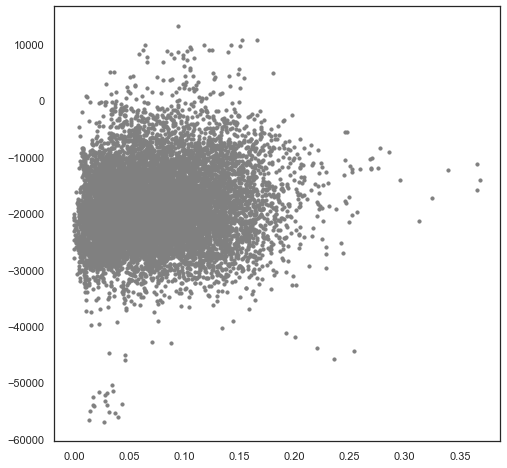

In [179]:
fig, axs = plt.subplots(ncols=1, figsize=(8,8))
plt.scatter(cds_ALL_df['250kb'], wins_500_df['deltaB0'], color = 'grey', s = 10)
plt.show()

### 3. The correlation between recombination and $\Delta B_0$ is negative:

$\Delta B_0$ is significantly correlated with $r$ over a range of scales. The strength of correlation increases with the physical scale over which r is measured but plateaus around 1Mb.

In [196]:
print("125kb", pearsonr(wins_500_df['rec_125Kb'], wins_500_df['deltaB0']))
print("250kb", pearsonr(wins_500_df['rec_250Kb'], wins_500_df['deltaB0']))
print("500kb", pearsonr(wins_500_df['rec_500Kb'], wins_500_df['deltaB0']))
print("1Mb", pearsonr(wins_500_df['rec_1000Kb'], wins_500_df['deltaB0']))
print("2Mb", pearsonr(wins_500_df['rec_2000Kb'], wins_500_df['deltaB0']))

125kb (-0.17991431145770315, 3.075872110684568e-82)
250kb (-0.21775975890226887, 1.6981164273984924e-120)
500kb (-0.23716374035834725, 3.3146327628840864e-143)
1Mb (-0.2501041702920993, 1.485704523497755e-159)
2Mb (-0.24983506934247507, 3.325576326499376e-159)


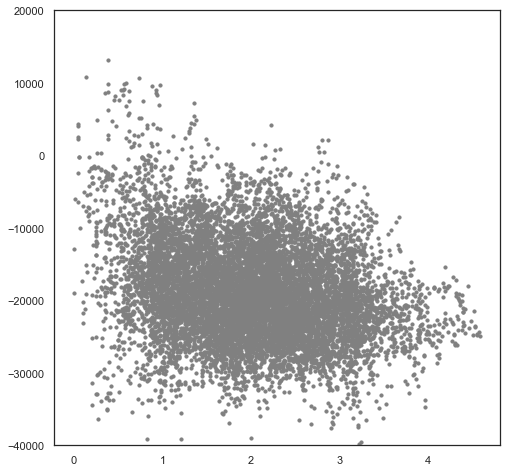

In [197]:
fig, axs = plt.subplots(ncols=1, figsize=(8,8))
plt.scatter(data =wins_500_df , x= 'rec_1000Kb', y = 'deltaB0', color = 'grey', s = 10)
plt.ylim(-40_000, 20_000)
plt.show()

The correlation is slightly stronger for mean $m_e$:

In [198]:
print("125kb", pearsonr(wins_500_df['rec_125Kb'], lik_best_pd_heli['me']))
print("250kb", pearsonr(wins_500_df['rec_250Kb'], lik_best_pd_heli['me']))
print("500kb", pearsonr(wins_500_df['rec_500Kb'], lik_best_pd_heli['me']))
print("1Mb", pearsonr(wins_500_df['rec_1000Kb'], lik_best_pd_heli['me']))
print("2Mb", pearsonr(wins_500_df['rec_2000Kb'], lik_best_pd_heli['me']))

125kb (0.19008166224977316, 9.505458860788105e-92)
250kb (0.2274315288692213, 1.5076794411825468e-131)
500kb (0.24917210972667944, 2.4107521503042553e-158)
1Mb (0.26419417251000177, 1.7789365605727547e-178)
2Mb (0.2646609197909698, 4.00929690697461e-179)


In [199]:
print("1Mb", pearsonr(wins_500_df[wins_500_df['∆B0 barrier'] == False]['rec_1000Kb'], wins_500_df[wins_500_df['∆B0 barrier'] == False]['me']))
print("1Mb", pearsonr(wins_500_df[wins_500_df['∆B02 barrier'] == False]['rec_1000Kb'], wins_500_df[wins_500_df['∆B02 barrier'] == False]['me']))

1Mb (0.25123168654369626, 8.599557682905414e-160)
1Mb (0.20712736885281297, 1.2149435581072761e-100)


... and weaker than the relation between recombination and $F_{st}$:

In [200]:
pearsonr(rec_1000kb_df['rec']/2, wins_500_df['f_st'])

(-0.49217384592901264, 0.0)

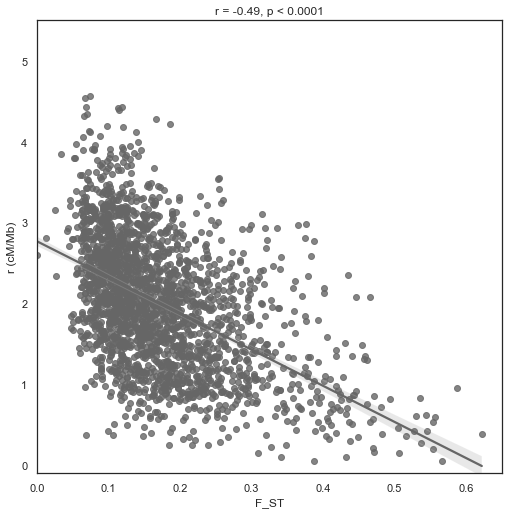

In [201]:
fig, axs = plt.subplots(ncols=1, figsize=(600*px,600*px))
sns.regplot(data=wins_500_df.iloc[::5, :], x="f_st",  y='rec_1000Kb', color = '0.4').set(title = 'r = -0.49, p < 0.0001')
plt.xlim(0,0.65)
plt.ylim(-0.1,5.5)
plt.ylabel('r (cM/Mb)')
plt.xlabel('F_ST')
plt.savefig("figures/fstvsRho.tiff", bbox_inches='tight')
plt.savefig("figures/fstvsRho.png", bbox_inches='tight')
plt.show()

## Low recombination regions are enriched for barriers

In [202]:
rec_barrier_125 =  wins_500_df[wins_500_df['∆B0 barrier']]['rec_125Kb']
rec_backG_125 = wins_500_df[wins_500_df['∆B0 barrier']== False]['rec_125Kb']
rec_barrier_500 =  wins_500_df[wins_500_df['∆B0 barrier']]['rec_500Kb']
rec_backG_500 = wins_500_df[wins_500_df['∆B0 barrier']== False]['rec_500Kb']
rec_barrier_1000 =  wins_500_df[wins_500_df['∆B0 barrier']]['rec_1000Kb']
rec_backG_1000 =wins_500_df[wins_500_df['∆B0 barrier']== False]['rec_1000Kb']

In [203]:
wins_500_df['N_cyd2'] = np.round(wins_500_df['N_cyd']/(1e6),2)
wins_500_df['N_mel2'] = np.round(wins_500_df['N_mel']/(1e6),2)
wins_500_df['me2'] = np.round(wins_500_df['me']*1e7,1)

Make a plot of $r$ per $m_e$ bin!

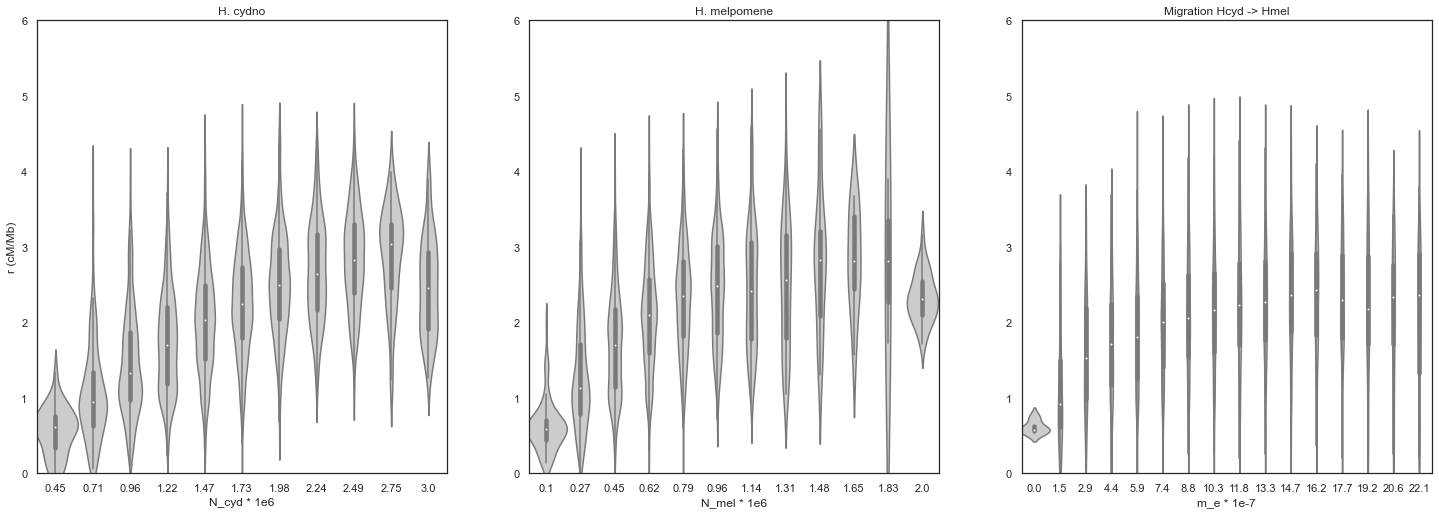

In [204]:
fig, axs = plt.subplots(ncols=3, figsize=(1800*px,600*px))
sns.violinplot(x='N_cyd2', y='rec_1000Kb', ax = axs[0], data=wins_500_df, color="0.8",width =1.2).set_title("H. cydno")
sns.violinplot(x='N_mel2', y='rec_1000Kb', ax = axs[1], data=wins_500_df, color="0.8",width =1.2).set_title("H. melpomene")
sns.violinplot(x='me2', y='rec_1000Kb', ax = axs[2], data=wins_500_df, color="0.8", width =1.2).set_title("Migration Hcyd -> Hmel")
axs[0].set_ylim(0,6)
axs[1].set_ylim(0,6)
axs[2].set_ylim(0,6)
axs[0].set_ylabel('r (cM/Mb)')
axs[1].set_ylabel(None)
axs[2].set_ylabel(None)
axs[0].set_xlabel('N_cyd * 1e6')
axs[1].set_xlabel('N_mel * 1e6')
axs[2].set_xlabel('m_e * 1e-7')
plt.savefig("figures/Ne_me_r_violins.png")
plt.show()

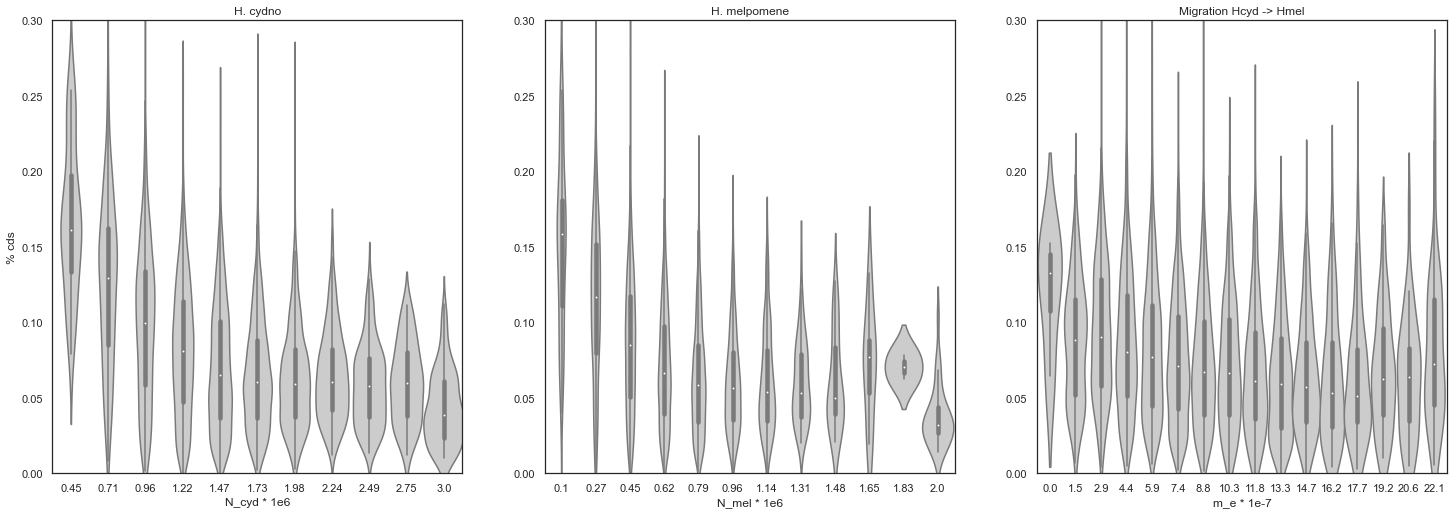

In [205]:
fig, axs = plt.subplots(ncols=3, figsize=(1800*px,600*px))
sns.violinplot(x='N_cyd2', y='CDS_250Kb', ax = axs[0], data=wins_500_df, color="0.8",width =1.1).set_title("H. cydno")
sns.violinplot(x='N_mel2', y='CDS_250Kb', ax = axs[1], data=wins_500_df, color="0.8",width =1.1).set_title("H. melpomene")
sns.violinplot(x='me2', y='CDS_250Kb', ax = axs[2], data=wins_500_df, color="0.8", width =1.1).set_title("Migration Hcyd -> Hmel")
axs[0].set_ylim(0,0.3)
axs[1].set_ylim(0,0.3)
axs[2].set_ylim(0,0.3)
axs[0].set_ylabel('% cds')
axs[1].set_ylabel(None)
axs[2].set_ylabel(None)
axs[0].set_xlabel('N_cyd * 1e6')
axs[1].set_xlabel('N_mel * 1e6')
axs[2].set_xlabel('m_e * 1e-7')
plt.savefig("figures/Ne_me_cds_violins.png")
plt.show()

The correlation between $\Delta B0$ and cds proportion is strongest at a 500kb scale:

In [206]:
print("125kb", pearsonr(wins_500_df['CDS_125Kb'], wins_500_df['deltaB0']))
print("250kb", pearsonr(wins_500_df['CDS_250Kb'], wins_500_df['deltaB0']))
print("500kb", pearsonr(wins_500_df['CDS_500Kb'], wins_500_df['deltaB0']))
print("1Mb", pearsonr(wins_500_df['CDS_1000Kb'], wins_500_df['deltaB0']))
print("2Mb", pearsonr(wins_500_df['CDS_2000Kb'], wins_500_df['deltaB0']))

125kb (0.11054804813637824, 7.682262346871068e-32)
250kb (0.12138538504958538, 4.370441263925598e-38)
500kb (0.12214192479592137, 1.5220532613093758e-38)
1Mb (0.09557454628929002, 3.50810248788886e-24)
2Mb (0.07201549248625443, 2.2363781774885593e-14)


The correlation between $m_e$ and cds proportion is strongest at a 250kb scale:

In [207]:
print("125kb", pearsonr(wins_500_df['CDS_125Kb'], lik_best_pd_heli['me']))
print("250kb", pearsonr(wins_500_df['CDS_250Kb'], lik_best_pd_heli['me']))
print("500kb", pearsonr(wins_500_df['CDS_500Kb'], lik_best_pd_heli['me']))
print("1Mb", pearsonr(wins_500_df['CDS_1000Kb'], lik_best_pd_heli['me']))
print("2Mb", pearsonr(wins_500_df['CDS_2000Kb'], lik_best_pd_heli['me']))

125kb (-0.16098375954698363, 5.29354238585825e-66)
250kb (-0.1638286026233166, 2.540396940425978e-68)
500kb (-0.14943256884723674, 5.0575041190253856e-57)
1Mb (-0.11823564273857817, 3.285585553516488e-36)
2Mb (-0.09664060196972954, 1.088097192607198e-24)


In [208]:
m = wins_500_df['rec_1000Kb'].mean()
m0 = wins_500_df[wins_500_df['∆B0 barrier']]['rec_1000Kb'].mean()
m1 = wins_500_df[wins_500_df['∆B02 barrier']]['rec_1000Kb'].mean()
med = wins_500_df['rec_1000Kb'].median()
med0 = wins_500_df[wins_500_df['∆B0 barrier']]['rec_1000Kb'].median()
med1 = wins_500_df[wins_500_df['∆B02 barrier']]['rec_1000Kb'].median()

In [209]:
print(np.around(np.array([m, m0,m1]),decimals = 3))
print(np.around(np.array([med, med0,med1]),decimals = 3))

[2.004 0.956 1.451]
[2.004 0.77  1.362]


In [210]:
wins_B0 = wins_500_df[wins_500_df['∆B0 barrier']]
wins_B02 = wins_500_df[wins_500_df['∆B02 barrier']]
wins_500_df['type'] = np.full(len(wins_500_df),'all')
wins_B0['type'] = np.full(len(wins_B0),'∆B0')
wins_B02['type'] = np.full(len(wins_B02),'∆B02')
newdf = pd.concat([wins_500_df,wins_B0,wins_B02])

In [211]:
cdsmed = wins_500_df['CDS_250Kb'].median()
cdsmed0 = wins_500_df[wins_500_df['∆B0 barrier']]['CDS_250Kb'].median()
cdsmed1 = wins_500_df[wins_500_df['∆B02 barrier']]['CDS_250Kb'].median()

cdsm = wins_500_df['CDS_250Kb'].mean()
cdsm0 = wins_500_df[wins_500_df['∆B0 barrier']]['CDS_250Kb'].mean()
cdsm1 = wins_500_df[wins_500_df['∆B02 barrier']]['CDS_250Kb'].mean()

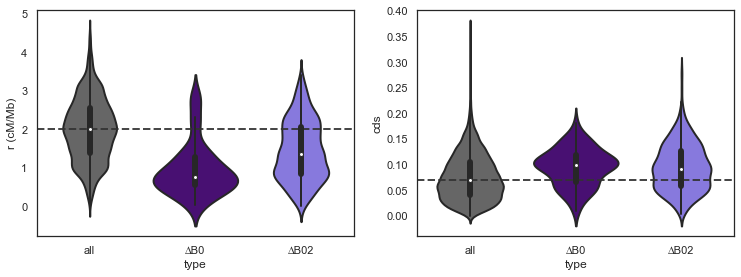

In [226]:
categories = pd.Series(newdf['type'])
newdf.rename(columns = {'rec_1000Kb':'r (cM/Mb)'}, inplace = True)
newdf.rename(columns = {'CDS_250Kb':'cds'}, inplace = True)
valuesRec = pd.Series(newdf['r (cM/Mb)'])
valuesCDS = pd.Series(newdf['cds'])
fig, axs = plt.subplots(ncols = 2, figsize=(900*px,300*px))
axs[0].axhline(y= med, linewidth=2, alpha=0.9, color ='0.2',ls = '--')
axs[1].axhline(y= cdsmed, linewidth=2, alpha=0.9, color ='0.2',ls = '--')
sns.violinplot(x=categories, y=valuesRec, linewidth=2, ax = axs[0], order=['all','∆B0','∆B02'], palette = ['0.4','indigo','mediumslateblue'])
sns.violinplot(x=categories, y=valuesCDS, linewidth=2, ax = axs[1], order=['all','∆B0','∆B02'], palette = ['0.4','indigo','mediumslateblue'])
plt.savefig("figures/r_cds_violin_final.png")
plt.savefig("figures/r_cds_violin_final.tiff")
plt.show()

# From sliding windows to genomic regions

In [227]:
import pybedtools

Once we have turned the outlier windows into bed format, we can use pybed to merge them and define regions: 

In [228]:
outlierbed0_heli = wins_500_df[wins_500_df['deltaB0'] > 0 ][['sequence', 'start', 'end']];
outlierBED0_heli = pybedtools.BedTool.from_dataframe(outlierbed0_heli);
outlierBED0mrgd_heli = outlierBED0_heli.merge();
outlierbed02_heli = wins_500_df[wins_500_df['deltaB02'] > 0 ][['sequence', 'start', 'end']];
outlierBED02_heli = pybedtools.BedTool.from_dataframe(outlierbed02_heli);
outlierBED02mrgd_heli = outlierBED02_heli.merge();

In [230]:
outlierBED0mrgd_heli.saveas('outlierBED0mrgd_heli.bed')
outlierBED0_heli.saveas('outlierBED0wins_heli.bed');

In [231]:
print('B0 outlier windows:', len(outlierBED0_heli), '; outlier regions:', outlierBED0mrgd_heli.count())
print('B1 outlier windows:', len(outlierBED02_heli), '; outlier regions:', outlierBED02mrgd_heli.count())

B0 outlier windows: 87 ; outlier regions: 25
B1 outlier windows: 871 ; outlier regions: 170


We can turn this back into a df:

In [232]:
wins_500_region_df0 = outlierBED0mrgd_heli.to_dataframe();
wins_500_region_df02 = outlierBED02mrgd_heli.to_dataframe();

In [233]:
pivot_table_heli0_med = pd.pivot_table(wins_500_region_df0, index='chrom', aggfunc=np.median)
pivot_table_heli02_med = pd.pivot_table(wins_500_region_df02, index='chrom', aggfunc=np.median)

The total span of barrier regions is 5 and 47 Mb:

In [234]:
outlierspans0_heli = (wins_500_region_df0['end']- wins_500_region_df0['start']);
outlierspans02_heli = (wins_500_region_df02['end']- wins_500_region_df02['start']);
wins_500_region_df0['spans'] = outlierspans0_heli/1e6
wins_500_region_df02['spans'] = outlierspans02_heli/1e6
print(outlierspans0_heli.sum())
print(outlierspans02_heli.sum())

4946997
47360079


Outlier regions defined by $\Delta B0$ and $\Delta B02$ span a fraction of 2% and 18% of autosomal sequence: 

In [238]:
genome_f = "laetsch_et_al_2023_data/gimble.autosomes.genomefile"
genome_df = pd.read_csv(genome_f, sep="\t", usecols=[0,1], names=['sequence_id', 'sequence_length'], dtype={'sequence_id': 'category', 'sequence_length': 'int64'}, header=None)
genome_df['sequence_id'] = genome_df['sequence_id'].str.replace('hmel2_5.','').str.replace('chr0','chr')
genome_pd = pd.pivot_table(genome_df, index='sequence_id')

Averaging estimates per chromosome:

In [239]:
pivot_table_best_heli = pd.pivot_table(lik_best_pd_heli, index='sequence', aggfunc=np.mean)

In [242]:
pivot_table_heli = pd.pivot_table(wins_500_region_df0, index='chrom', aggfunc=np.sum)
pivot_table_heli02 = pd.pivot_table(wins_500_region_df02, index='chrom', aggfunc=np.sum)
pivot_table_best_heli['len'] = genome_pd['sequence_length']

In [243]:
total_auto = pivot_table_best_heli.len.sum()
print(outlierspans0_heli.sum()/total_auto)
print(outlierspans02_heli.sum()/total_auto)

0.019079953368519406
0.1826619459945893


The median span of barrier regions is 186 and 240Mb:

In [244]:
median_out0 = wins_500_region_df0['spans'].median()
median_out02 = wins_500_region_df02['spans'].median()
print(median_out0,median_out02)

0.186388 0.24063600000000002


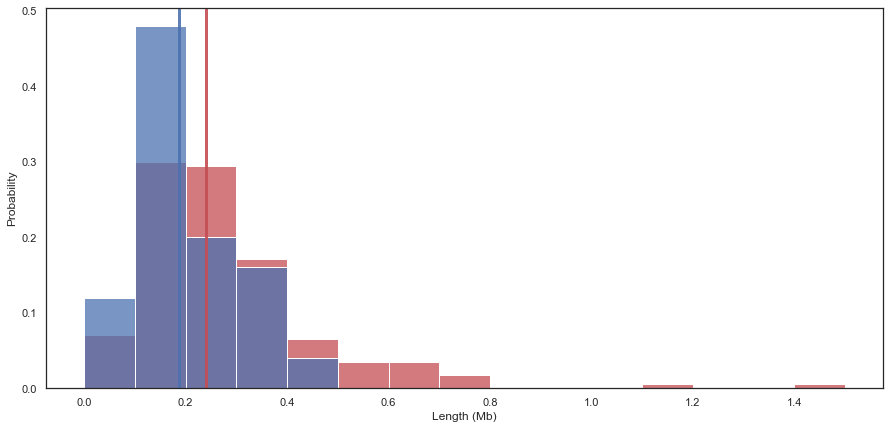

In [245]:
sns.set_theme(style="white")
plt.axvline(x = median_out0, linewidth=3, alpha=0.9, color ='b')
plt.axvline(x = median_out02, linewidth=3, alpha=0.9, color ='r')
plt.xlabel('Length (Mb)')
sns.histplot(data = wins_500_region_df02, x = 'spans', binrange = (0,1.5), binwidth = 0.1, stat = "probability", color= 'r')
sns.histplot(data = wins_500_region_df0, x = 'spans', binrange = (0,1.5), binwidth = 0.1, stat = "probability", color= 'b')
plt.savefig("figures/region_hist.png")
plt.show()

The longest region is 400kb:

In [246]:
print(outlierspans0_heli.min())
print(outlierspans0_heli.max())

89621
407720


## Correlations between $m_e$ (and $N_e$) and chromosome length

In [247]:
pivot_table_best_heli['barrier_frac'] = (1e6 * pivot_table_heli['spans'])/pivot_table_best_heli['len']
pivot_table_best_heli['barrier_frac'] = pivot_table_best_heli['barrier_frac'].fillna(0)
pivot_table_best_heli['barrier_frac02'] = (1e6 * pivot_table_heli02['spans'])/pivot_table_best_heli['len']
pivot_table_best_heli['barrier_frac02'] = pivot_table_best_heli['barrier_frac02'].fillna(0)

Mean $N_e$ and $m_e$ estimates are negatively correlated with chromosome length: 

In [248]:
pearsonr(pivot_table_best_heli.len, pivot_table_best_heli.Ne_B)

(-0.8599734537900261, 1.1691692294437591e-06)

In [249]:
pearsonr(pivot_table_best_heli.len, pivot_table_best_heli.Ne_A)

(-0.9248812533657309, 5.4948495629113255e-09)

In [250]:
pearsonr(pivot_table_best_heli.len, pivot_table_best_heli.me)

(-0.6339655676648609, 0.0026851673847437573)

In [251]:
pivot_table_best_heli['len'] = pivot_table_best_heli['len']/1e6

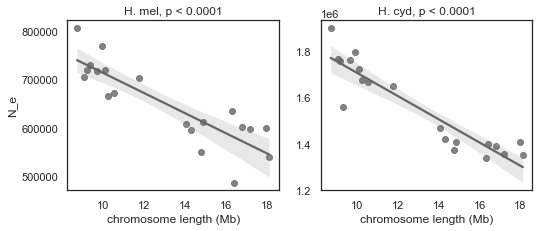

In [261]:
fig,axs = plt.subplots(ncols=2, figsize=(600*px,225*px))
sns.regplot(data=pivot_table_best_heli, ax = axs[0], x='len', y="Ne_B", color = '0.4').set(title = 'H. mel, p < 0.0001')
sns.regplot(data=pivot_table_best_heli, ax = axs[1], x='len', y="Ne_A", color = '0.4').set(title = 'H. cyd, p < 0.0001')
axs[0].set_ylabel('N_e')
axs[1].set_ylabel(None)
axs[0].set_xlabel('chromosome length (Mb)')
axs[1].set_xlabel('chromosome length (Mb)')
plt.savefig("figures/Ne_both_Len.png", bbox_inches='tight')
plt.savefig("figures/Ne_both_Len.tiff", bbox_inches='tight')
plt.show()

Chromsome wide means of $N_e$ and $m_e$ are positively correlated:

In [262]:
pearsonr(pivot_table_best_heli.me, pivot_table_best_heli.Ne_A)

(0.6447512895619883, 0.0021470356352225836)

In [263]:
pearsonr(pivot_table_best_heli.me, pivot_table_best_heli.Ne_B)

(0.7892808488642399, 3.5167093148848576e-05)

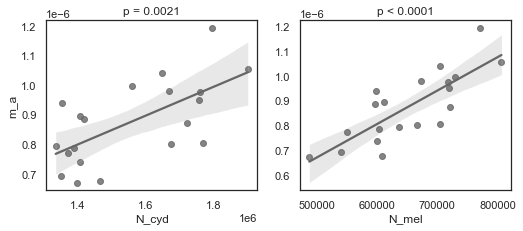

In [264]:
fig,axs = plt.subplots(ncols=2, figsize=(600*px,225*px))
sns.regplot(data=pivot_table_best_heli, x='Ne_A', ax = axs[0], y="me", color = '0.4').set(title = 'p = 0.0021' )
sns.regplot(data=pivot_table_best_heli, x='Ne_B', ax = axs[1], y="me", color = '0.4').set(title = 'p < 0.0001' )
axs[0].set_ylabel('m_a')
axs[1].set_ylabel(None)
axs[0].set_xlabel('N_cyd')
axs[1].set_xlabel('N_mel')
plt.savefig("figures/me_Neheli.png", bbox_inches='tight')
plt.savefig("figures/me_Neheli.tiff", bbox_inches='tight')
plt.show()

There is no significant relation between the fraction of barrier sequence and chrom length. Nor between mean m_e and chrom len...

In [265]:
pearsonr(pivot_table_best_heli.len, pivot_table_best_heli.barrier_frac)

(0.2495892747400645, 0.28858200305776555)

In [266]:
pearsonr(pivot_table_best_heli.len, pivot_table_best_heli.barrier_frac02)

(0.4240485556338652, 0.06241441257973545)

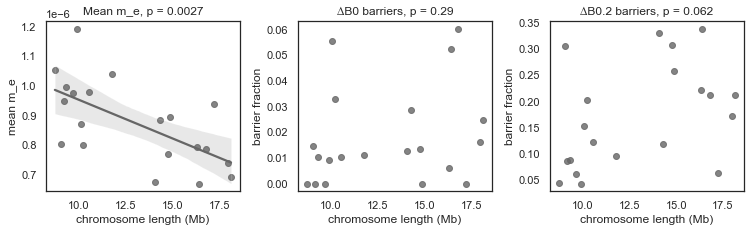

In [267]:
fig, axs = plt.subplots(ncols=3, figsize=(900*px,225*px), sharex = True)
plt.subplots_adjust(wspace=0.3)
sns.regplot(data=pivot_table_best_heli, ax = axs[0], x='len', y="me", color = '0.4').set(title = 'Mean m_e, p = 0.0027')
sns.regplot(data=pivot_table_best_heli, ax = axs[1], x='len', y="barrier_frac", color = '0.4', fit_reg=False).set(title = "∆B0 barriers, p = 0.29")
sns.regplot(data=pivot_table_best_heli, ax = axs[2], x='len', y="barrier_frac02", color = '0.4', fit_reg=False).set(title = "∆B0.2 barriers, p = 0.062")
axs[0].set_ylabel('mean m_e')
axs[1].set_ylabel('barrier fraction')
axs[2].set_ylabel('barrier fraction')
axs[0].set_xlabel('chromosome length (Mb)')
axs[1].set_xlabel('chromosome length (Mb)')
axs[2].set_xlabel('chromosome length (Mb)')
plt.savefig("figures/me_Len_heliv3.png", bbox_inches='tight')
plt.savefig("figures/me_Len_heliv3.tiff", bbox_inches='tight')
plt.show()